# House sales predictions

## Introduction

In this lab the objective is to predict the price of a house based on its features. We have some training data containing 79 features excluding the Id and sales price. And some test data containg those same features but not the sales price. To predict the values of these test houses we have to make some models, that use these supplied features and turns them into a prediction of the value. Before we can start the prediction, we first need to explore the data for features correlating to the price, and abnormalities that may interfare with our predictions. Then we need to enginer our own features to increase the accuracy of our model. Finaly we need to choose the model for our prediction.

## Table of content
1. [Cleaning the data](#first-bullet)

2. [Data Exploration](#second-bullet)
    
    2.1 [Finding feature relations](#third-bullet)
    
    2.2 [Lets plot some features](#fourth-bullet)

## Short summary

## Imports

In [321]:
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import lightgbm as lgb
import xgboost as xgb
import matplotlib.ticker as ticker
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression , Ridge , Lasso , BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.svm import SVR


#sns.set_style('white')
pd.set_option('display.max_columns', None)
base = "./challenge_data/"

## Reading the data

In [322]:
# loading the data
houseDataDF = pd.read_csv(base + "train.csv")
idColl = houseDataDF.Id
houseDataDF = houseDataDF.drop(["Id"],axis=1)
houseDataDF.index = idColl
trainSetLength = len(houseDataDF.values)
print(houseDataDF.shape)

testDF = pd.read_csv(base + "test.csv")
testIdColl = testDF.Id
testDF = testDF.drop(["Id"],axis=1)
testDF.index = testIdColl
print(testDF.shape)

usBondsDF = pd.read_csv(base + "T10Y2Y.csv")
usBondsDF.T10Y2Y = usBondsDF.T10Y2Y.apply(lambda x :0.0 if x == "." else float(x)).apply(lambda x : x * 100)
usBondsDF.DATE = usBondsDF.DATE.apply(lambda x : x[:-3])
idColl = usBondsDF.DATE
usBondsDF.index = idColl
usBondsDF = usBondsDF.drop(["DATE"],axis=1)

vacencyDF = pd.read_csv(base + "ILRVAC.csv")
#vacencyDF.ILRVAC = vacencyDF.ILRVAC.apply(lambda x : x * 10)
vacencyDF.DATE = vacencyDF.DATE.apply(lambda x : x[:4])
idColl = vacencyDF.DATE
vacencyDF.index = idColl
vacencyDF = vacencyDF.drop(["DATE"],axis=1)



housingPrisesIndexDF = pd.read_csv(base + "CSUSHPINSA.csv")
housingPrisesIndexDF.CSUSHPINSA_diff = housingPrisesIndexDF.CSUSHPINSA_diff.apply(lambda x :0.0 if x == "NaN" else float(x)).apply(lambda x : x + 3.525000)
housingPrisesIndexDF.DATE = housingPrisesIndexDF.DATE.apply(lambda x : x[:-3])
idColl = housingPrisesIndexDF.DATE
housingPrisesIndexDF.index = idColl
housingPrisesIndexDF = housingPrisesIndexDF.drop(["DATE"],axis=1)
housingPrisesIndexDF.describe()


(1200, 80)
(260, 79)


,CSUSHPINSA,CSUSHPINSA_diff
count,72.000000,7.200000e+01
mean,165.418722,3.254083e+00
std,15.307946,1.456227e+00
min,140.630000,-9.769963e-15
25%,148.493500,2.250250e+00
50%,167.181000,3.235500e+00
75%,180.874750,4.248750e+00
max,184.615000,6.175000e+00


In [323]:
def findBondsValueByDate(year,month):
    if month < 10:
        month = "0"+str(month)
    date = str(year)+"-"+str(month)
    res = usBondsDF.loc[date][0]
    return res

def findVacencyByYear(year):
    res = vacencyDF.loc[str(year)][0]
    return res

def findHousePriceIndexByDate(year,month):
    if month < 10:
        month = "0"+str(month)
    date = str(year)+"-"+str(month)
    res = housingPrisesIndexDF.loc[date]["CSUSHPINSA_diff"]    
    return res

houseDataDF["USBonds"] = [findBondsValueByDate(x,y) for x,y in zip(houseDataDF.YrSold,houseDataDF.MoSold)]
testDF["USBonds"] = [findBondsValueByDate(x,y) for x,y in zip(testDF.YrSold,testDF.MoSold)]

houseDataDF["Vacency"] = [findVacencyByYear(x) for x in houseDataDF.YrSold]
testDF["Vacency"] = [findVacencyByYear(x) for x in testDF.YrSold]

houseDataDF["HousePriceIndex"] = [findHousePriceIndexByDate(x,y) for x,y in zip(houseDataDF.YrSold,houseDataDF.MoSold)]
testDF["HousePriceIndex"] = [findHousePriceIndexByDate(x,y) for x,y in zip(testDF.YrSold,testDF.MoSold)]

# Data Exploration

Lets first see how many of the values in data than are empty, None or NAN.

Text(0.5,1,'Percent missing data by feature (training data)')

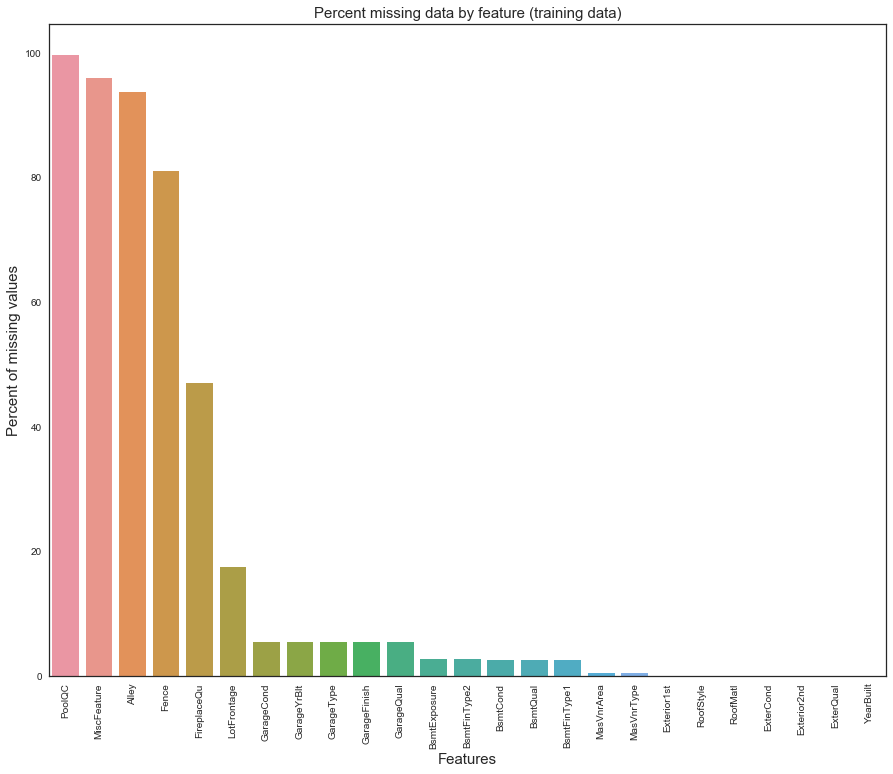

In [324]:
nulls = pd.DataFrame(houseDataDF.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=list(nulls.index), y=nulls.values.ravel() * 100 /len(houseDataDF.values))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature (training data)', fontsize=15)

We can see from the plot above that for several features for the training data, over 80% of the values are missing. Lets see if the same applies for the test data.

Text(0.5,1,'Percent missing data by feature (test data)')

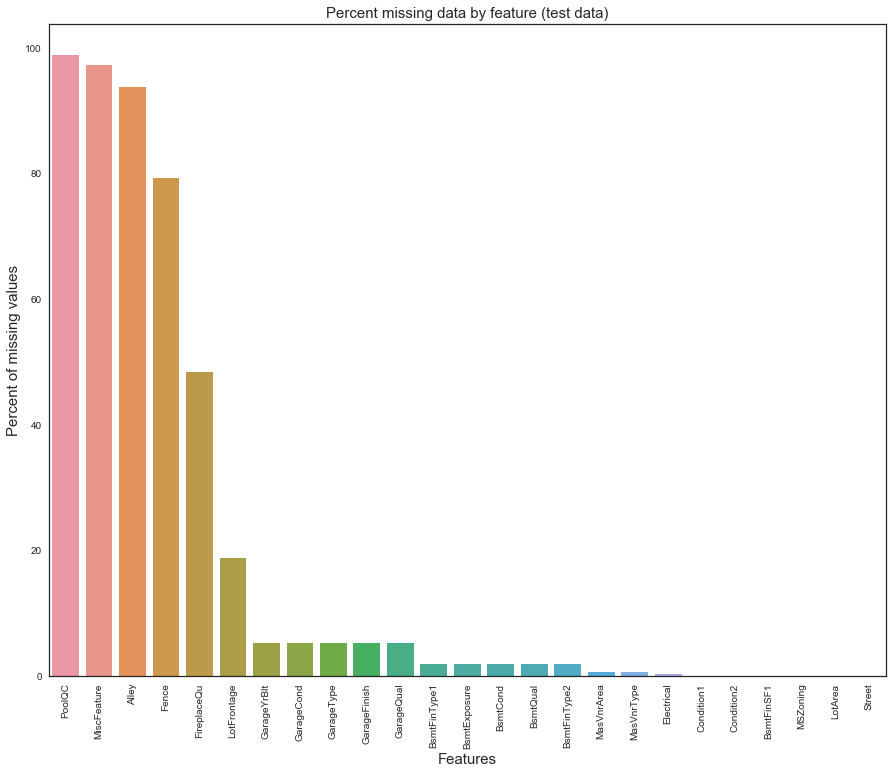

In [325]:
nulls = pd.DataFrame(testDF.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=list(nulls.index), y=nulls.values.ravel() * 100 /len(testDF.values))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature (test data)', fontsize=15)

We can see that the percentage of missing values are almost the same for test data as the training data. This is good news, as our predictions are not going to be biased by missing values.

Our data consists of both numerical and caterical features. For making predictions we need to see how these values are distributed. Lets first look at the numerical features from the training data.

In [326]:
numericals = houseDataDF.select_dtypes(include=[np.number])
numericals.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,USBonds,Vacency,HousePriceIndex
count,1200.000000,990.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1194.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1133.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1.200000e+03
mean,57.075000,70.086869,10559.411667,6.105000,5.568333,1971.350833,1984.987500,103.962312,444.886667,45.260000,564.553333,1054.700000,1157.430833,344.993333,6.553333,1508.97750,0.421667,0.061667,1.560833,0.382500,2.857500,1.045000,6.494167,0.614167,1978.368932,1.763333,472.604167,95.136667,46.016667,22.178333,3.653333,14.980833,1.909167,40.453333,6.311667,2007.810833,181414.628333,124.845058,10.944667,3.270694e+00
std,42.682012,23.702029,10619.135549,1.383439,1.120138,30.048408,20.527221,183.534953,439.987844,158.931453,440.388327,419.996306,375.238607,437.038023,52.077992,517.38033,0.520342,0.247484,0.552165,0.499735,0.819199,0.219123,1.614664,0.642113,24.812865,0.743494,212.722444,124.034129,65.677629,61.507323,29.991099,54.768057,33.148327,482.323444,2.673104,1.319027,81070.908544,108.731829,0.914641,1.173305e+00
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,-14.523810,10.000000,-9.769963e-15
25%,20.000000,59.000000,7560.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,225.000000,796.000000,882.000000,0.000000,0.000000,1125.75000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000,10.157895,10.400000,2.704000e+00
50%,50.000000,70.000000,9434.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,385.500000,0.000000,472.000000,1002.500000,1087.000000,0.000000,0.000000,1456.00000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,478.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163700.000000,143.428571,10.800000,3.248000e+00
75%,70.000000,80.000000,11616.000000,7.000000,6.000000,2000.000000,2004.000000,166.750000,712.250000,0.000000,799.500000,1298.250000,1390.250000,728.000000,0.000000,1764.50000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,244.571429,11.000000,4.188000e+00
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1474.000000,2336.000000,3206.000000,3228.000000,2065.000000,572.000000,4676.00000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1390.000000,857.000000,523.000000,552.000000,508.000000,410.000000,648.000000,15500.000000,12.000000,2010.000000,755000.000000,283.421053,12.600000,5.323000e+00


In [327]:
categoricals = houseDataDF.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1200,1200,75,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1194,1200,1200,1200,1168,1168,1167,1168,1167,1200,1200,1200,1200,1200,1200,636,1133,1133,1133,1133,1200,4,227,47,1200,1200
unique,5,2,2,4,4,2,5,3,25,9,7,5,8,5,6,14,15,4,4,5,6,4,4,4,6,6,4,5,2,5,4,7,5,6,3,5,5,3,3,4,3,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,946,1194,41,754,1079,1199,862,1135,179,1035,1186,1001,601,945,1178,417,410,711,747,1050,534,526,1076,784,346,1034,1177,603,1122,1095,602,1117,309,718,500,1081,1093,1107,2,130,44,1036,979


In [328]:
numericals = testDF.select_dtypes(include=[np.number])
numericals.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,USBonds,Vacency,HousePriceIndex
count,260.000000,211.000000,260.000000,260.000000,260.000000,260.000000,260.000000,258.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,246.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,2.600000e+02
mean,56.076923,69.876777,10320.288462,6.073077,5.607692,1970.884615,1984.303846,102.403101,437.884615,52.500000,579.642308,1070.026923,1186.607692,356.219231,2.573077,1545.400000,0.442308,0.038462,1.584615,0.384615,2.907692,1.053846,6.626923,0.607692,1979.138211,1.784615,474.715385,90.126923,49.630769,20.919231,2.284615,15.430769,6.680769,57.500000,6.369231,2007.838462,128.542954,10.999231,3.283350e+00
std,40.563048,26.911212,6255.537115,1.383314,1.079798,30.962085,21.213658,169.505783,524.993497,172.108108,449.278872,517.092050,435.144036,434.888547,27.379755,561.432388,0.512902,0.192679,0.545740,0.518159,0.800059,0.226149,1.672872,0.657551,24.154038,0.765921,219.140520,131.361754,68.915161,59.399547,26.005564,60.224091,63.147817,556.196665,2.845137,1.371547,110.196122,0.948642,1.236316e+00
min,20.000000,21.000000,1533.000000,3.000000,3.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,483.000000,0.000000,0.000000,630.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,1914.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,-14.523810,10.000000,-9.769963e-15
25%,20.000000,59.500000,7500.000000,5.000000,5.000000,1950.000000,1966.000000,0.000000,0.000000,0.000000,216.000000,790.250000,884.000000,0.000000,0.000000,1143.250000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,6.000000,0.000000,1962.250000,1.000000,332.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.750000,2007.000000,-0.909091,10.400000,2.704000e+00
50%,50.000000,67.000000,9600.000000,6.000000,5.000000,1971.500000,1992.000000,0.000000,360.000000,0.000000,514.000000,946.000000,1086.000000,0.000000,0.000000,1510.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.000000,2.000000,484.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,143.454545,10.800000,3.248000e+00
75%,70.000000,80.000000,11515.500000,7.000000,6.000000,2001.250000,2004.000000,160.000000,704.750000,0.000000,841.750000,1289.500000,1407.750000,739.500000,0.000000,1844.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,8.000000,1.000000,2003.000000,2.000000,573.000000,168.000000,70.500000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,243.857143,11.000000,4.202500e+00
max,190.000000,313.000000,63887.000000,10.000000,9.000000,2009.000000,2009.000000,796.000000,5644.000000,1031.000000,2002.000000,6110.000000,4692.000000,1611.000000,384.000000,5642.000000,2.000000,1.000000,3.000000,2.000000,6.000000,2.000000,12.000000,3.000000,2009.000000,4.000000,1418.000000,736.000000,547.000000,301.000000,304.000000,480.000000,738.000000,8300.000000,12.000000,2010.000000,283.421053,12.600000,5.323000e+00


In [329]:
categoricals = testDF.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,260,260,16,260,260,260,260,260,260,260,260,260,260,260,260,260,260,258,260,260,260,255,255,255,255,255,260,260,260,259,260,260,134,246,246,246,246,260,3,54,7,260,260
unique,5,1,2,4,4,1,5,3,24,8,2,5,8,6,5,11,12,4,4,3,6,4,3,4,6,6,6,4,2,3,4,5,5,5,3,3,4,3,2,4,3,5,5
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,205,260,9,171,232,260,190,247,46,225,259,219,125,196,256,98,94,153,159,232,113,123,235,169,86,222,251,138,243,239,133,243,71,152,105,230,233,233,2,27,5,231,219


## Finding feature relations

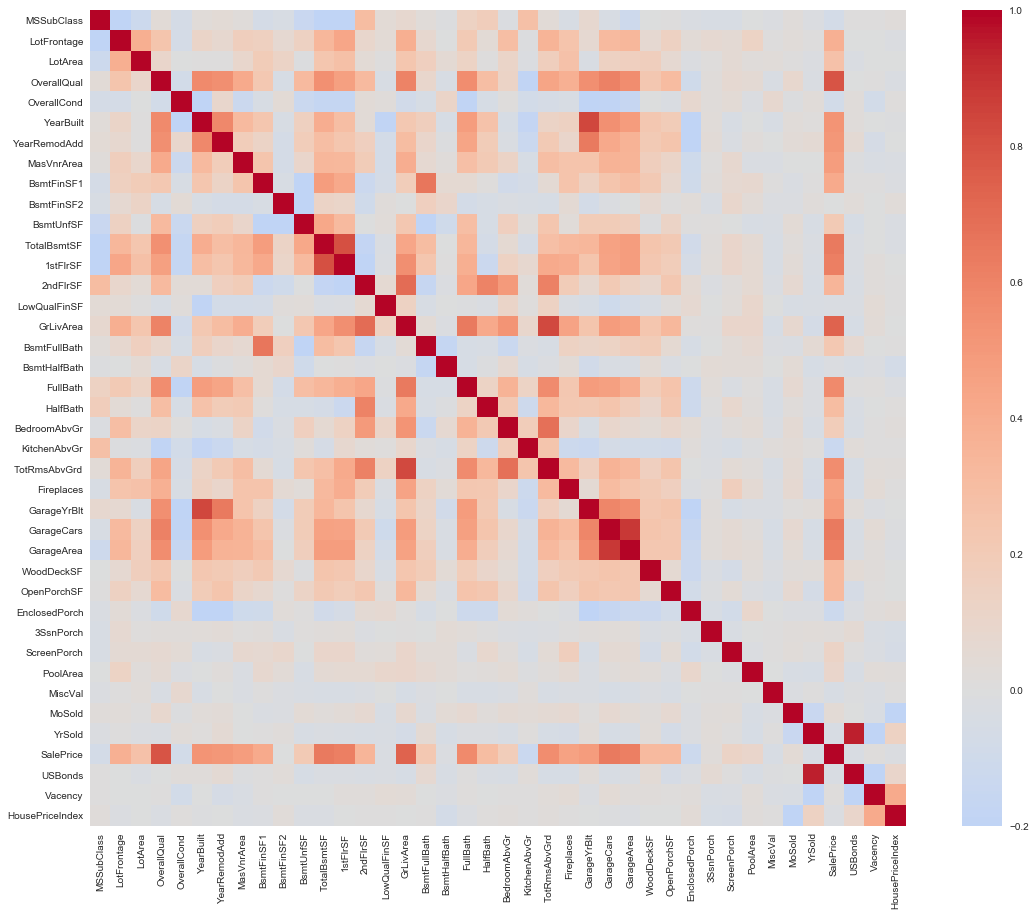

In [330]:
plt.figure(figsize=(20,15))
corr = houseDataDF.corr()


sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            vmin=-0.2, square=True, center=0,cmap='coolwarm'
           )

In [331]:

corrAsList = list(zip(corr.tail(4).values[0],list(corr)))

sortedCorr = sorted(corrAsList,key=lambda x : x[0],reverse=True)

corrDF = pd.DataFrame(data=np.array(sortedCorr),columns=["Correlation","Feature"])
highestCorrFeatures = corrDF["Feature"].values[1:11]
corrDF

,Correlation,Feature
0,1.0,SalePrice
1,0.7891424854776941,OverallQual
2,0.7403792470454845,GrLivArea
3,0.6419166279661711,TotalBsmtSF
4,0.64096125033065,GarageCars
5,0.6233291704658925,GarageArea
6,0.6185556125238022,1stFlrSF
7,0.5718673954241766,FullBath
8,0.5594350061389467,TotRmsAbvGrd
9,0.5231935965259926,YearBuilt


## Lets plot some features

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

/home/marius/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


count      1200.000000
mean     181414.628333
std       81070.908544
min       34900.000000
25%      129900.000000
50%      163700.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

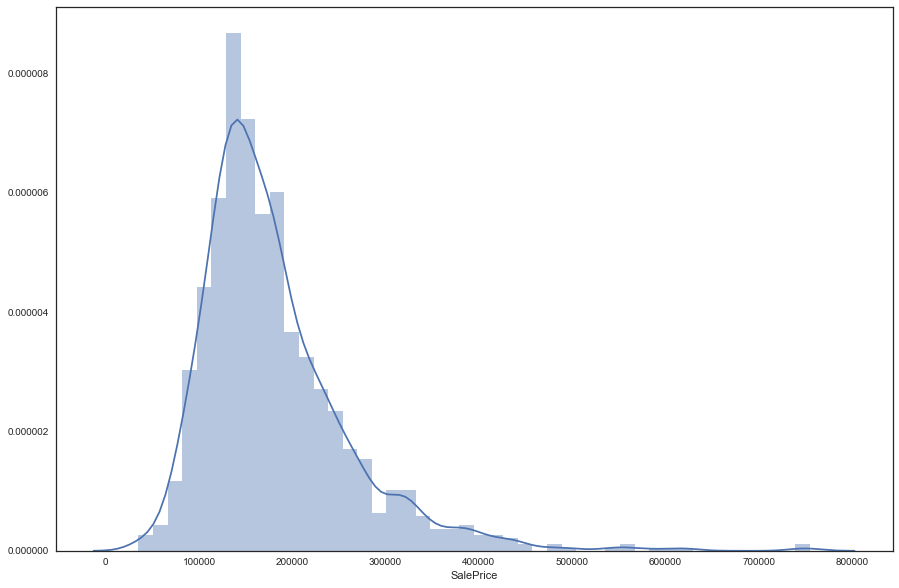

In [332]:
plt.figure(figsize=(15,10))
sns.distplot(houseDataDF.SalePrice)
houseDataDF.SalePrice.describe()

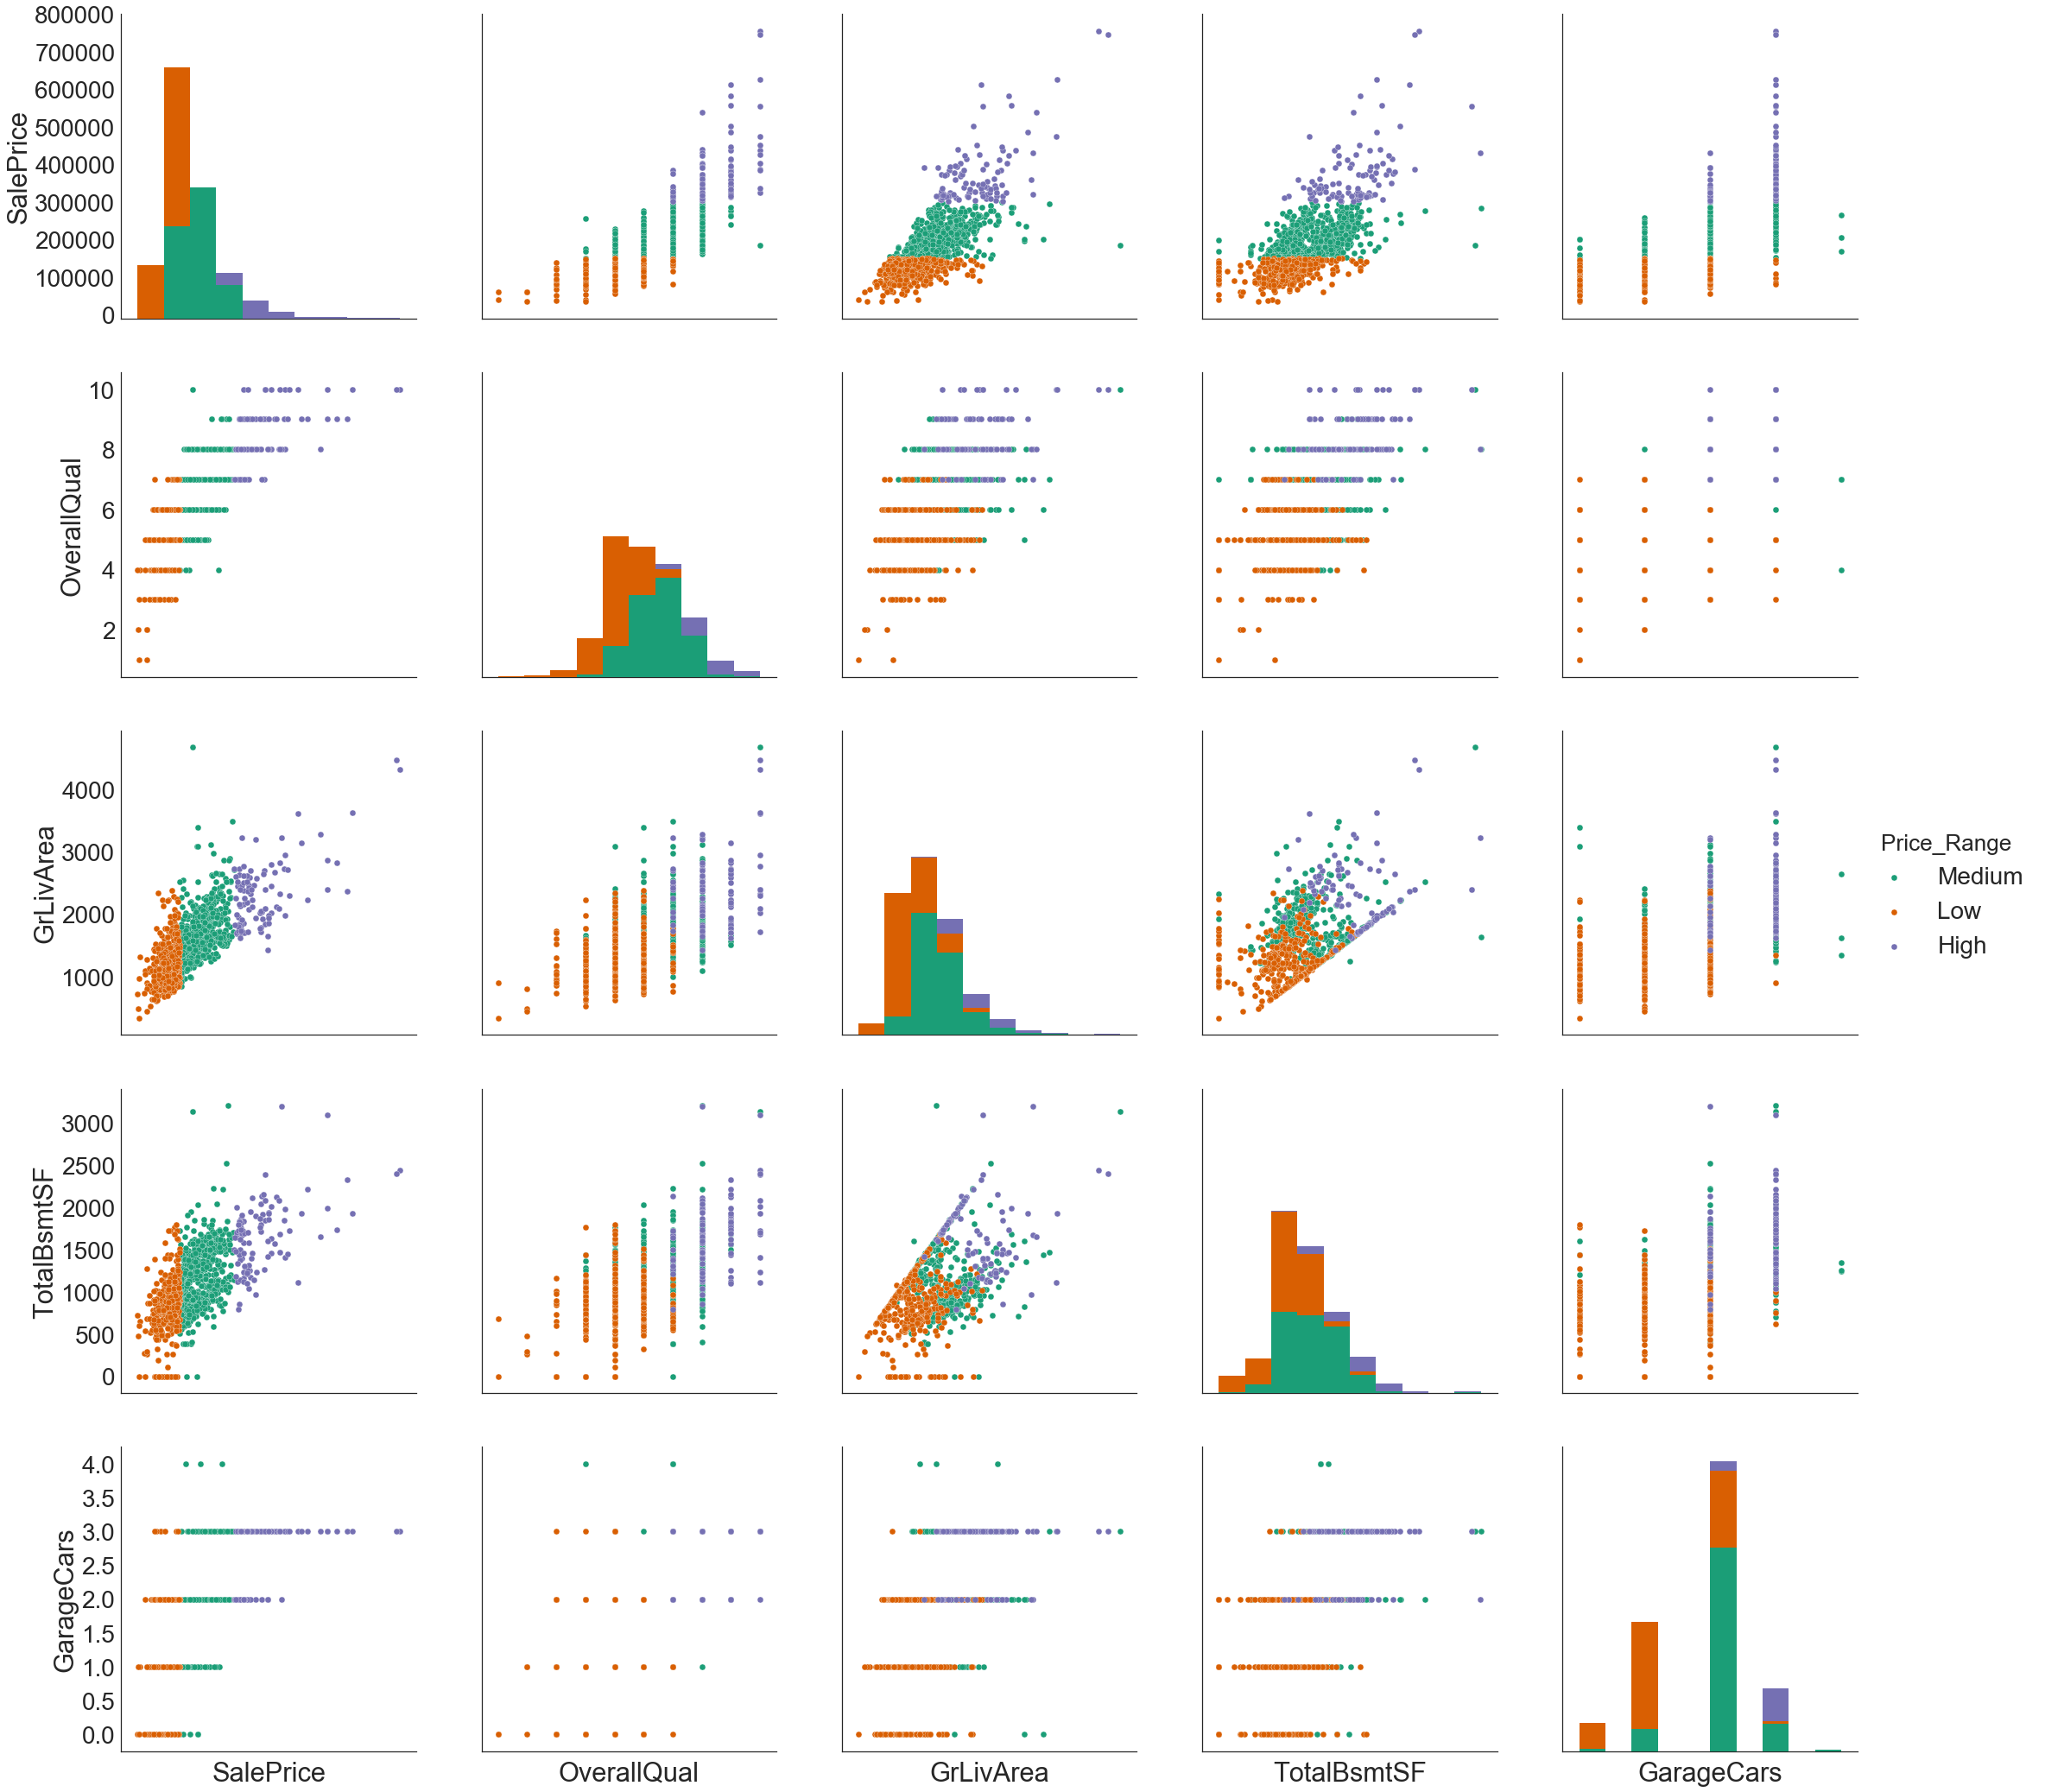

In [333]:
def findPriceRange(x):
    if x < 150000:
        return "Low"
    if x < 300000:
        return "Medium"
    return "High"

houseDataDF["Price_Range"] = [findPriceRange(x) for x in houseDataDF.SalePrice]
features = corrDF["Feature"].values[:5]

with sns.plotting_context("notebook",font_scale=2.8):
    g = sns.pairplot(houseDataDF,vars=features,palette="Dark2", size=6,hue="Price_Range")
    
g.set(xticklabels=[]);
plt.show()


### OverallQual

/home/marius/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


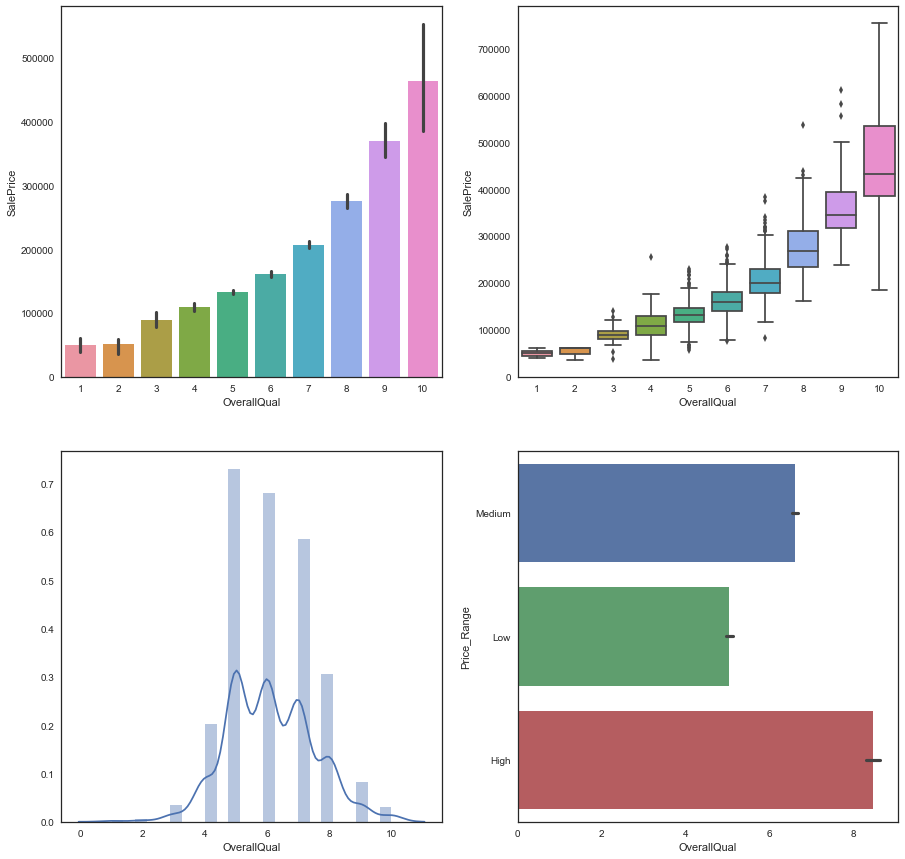

In [334]:
plt.figure(figsize=(15,15))
plt.subplot(221)
sns.barplot(x="OverallQual", y="SalePrice", data=houseDataDF)
plt.subplot(222)
sns.boxplot(x='OverallQual',y='SalePrice', data=houseDataDF)
plt.subplot(223)
sns.distplot(houseDataDF.OverallQual)
plt.subplot(224)
sns.barplot(x="OverallQual",y="Price_Range",data=houseDataDF)

### Area features

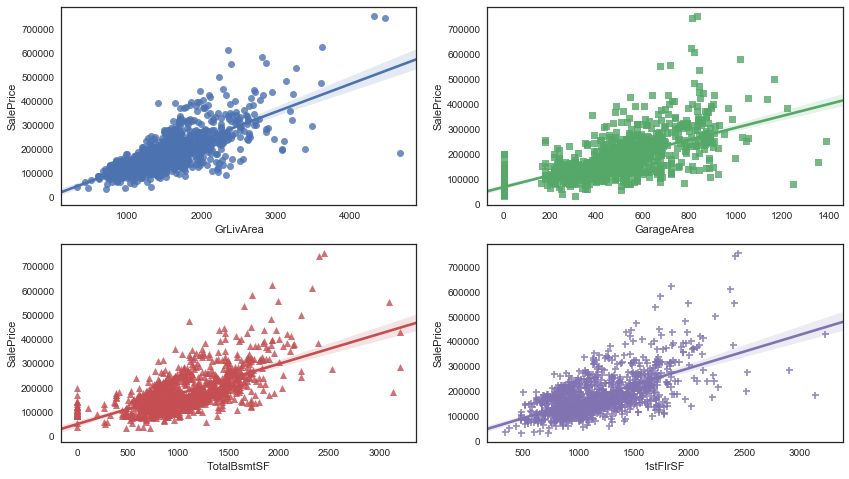

In [335]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(14,8))

data = pd.concat([houseDataDF['SalePrice'], houseDataDF['GrLivArea']], axis=1)
sns.regplot(x='GrLivArea', y='SalePrice', data=data, fit_reg=True, ax=ax1)
 
data = pd.concat([houseDataDF['SalePrice'], houseDataDF['GarageArea']], axis=1)
sns.regplot(x='GarageArea', y='SalePrice', data=data, fit_reg=True, ax=ax2, marker='s')

data = pd.concat([houseDataDF['SalePrice'], houseDataDF['TotalBsmtSF']], axis=1)
sns.regplot(x='TotalBsmtSF', y='SalePrice', data=data, fit_reg=True, ax=ax3, marker='^')

data = pd.concat([houseDataDF['SalePrice'], houseDataDF['1stFlrSF']], axis=1)
sns.regplot(x='1stFlrSF', y='SalePrice', data=data, fit_reg=True, ax=ax4, marker='+')

plt.show()

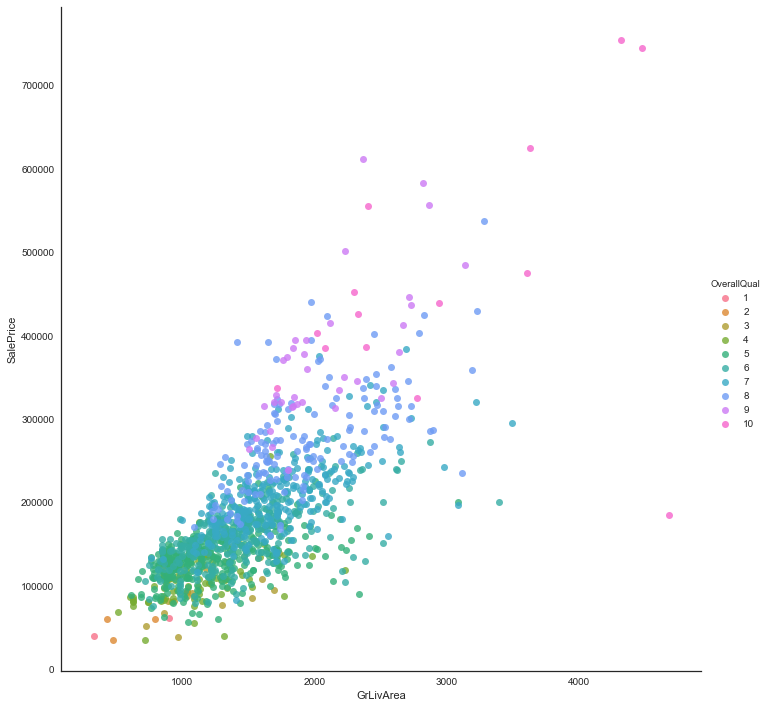

In [336]:
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataDF,fit_reg=False,size=10,hue="OverallQual") 

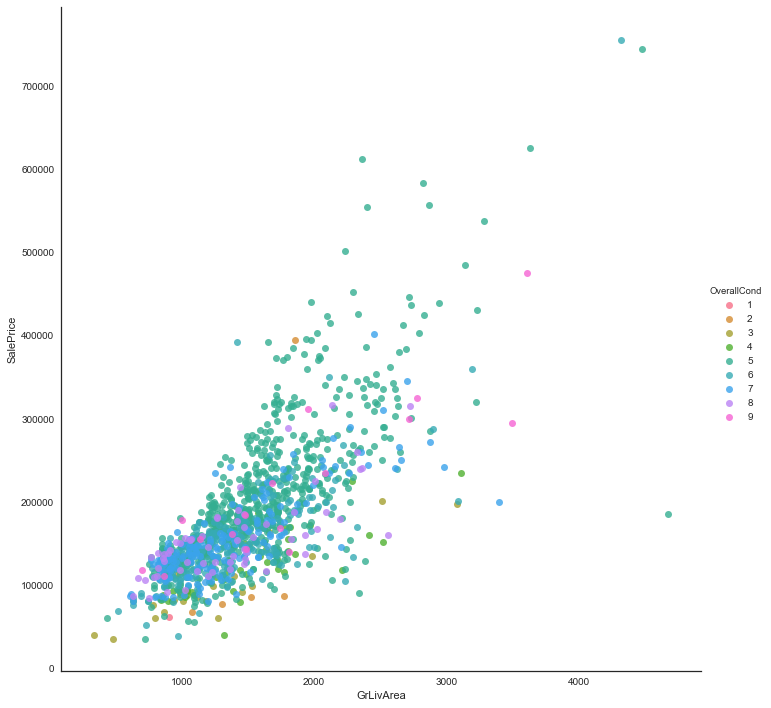

In [337]:
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataDF,fit_reg=False,size=10,hue="OverallCond") 

In [338]:
res = houseDataDF.query('SalePrice <= 200000 & OverallQual == 10 ')[highestCorrFeatures]
outliers = res.index.values
res

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,GarageArea,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
Id,,,,,,,,,,
524,10,4676,3138,3,884,3138,3,11,2007,2008


### Neighbourhood

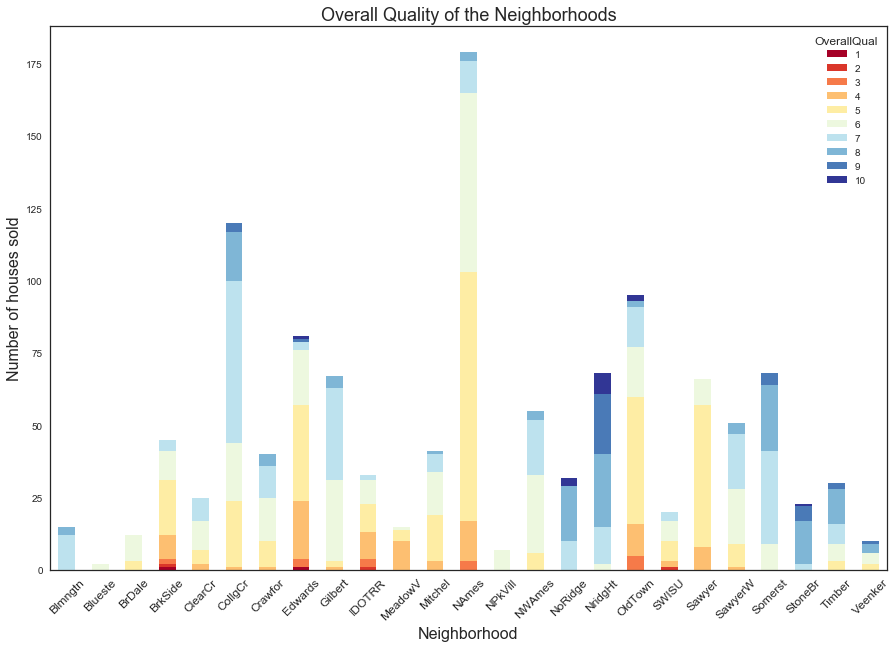

In [339]:
plt.style.use('seaborn-white')
types_foundations = houseDataDF.groupby(['Neighborhood', 'OverallQual']).size()
types_foundations.unstack().plot(kind='bar', stacked=True, colormap='RdYlBu', figsize=(15,10), grid=False)
plt.ylabel('Number of houses sold', fontsize=16)
plt.xlabel('Neighborhood', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.title('Overall Quality of the Neighborhoods', fontsize=18)
plt.show()

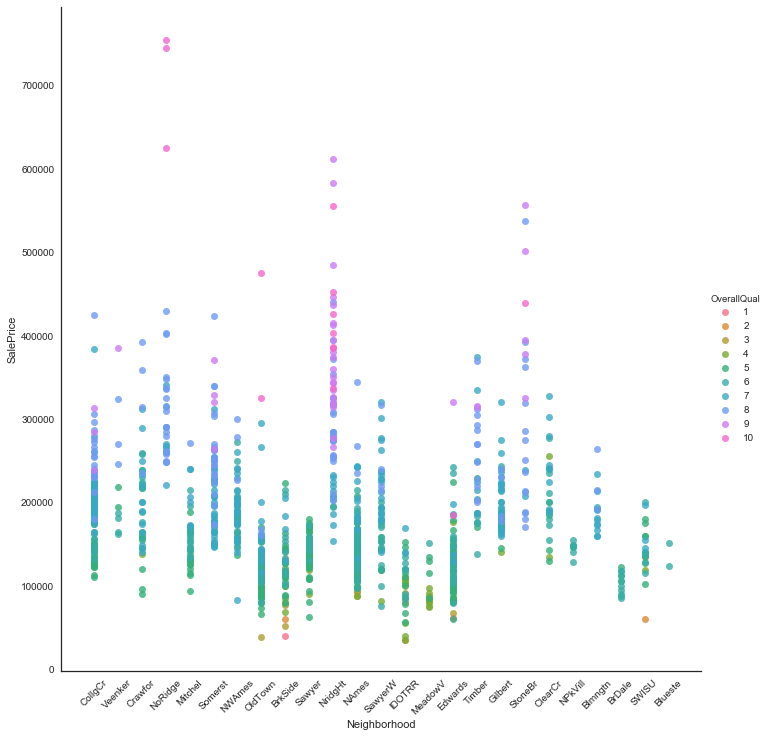

In [340]:
h = sns.lmplot(x="Neighborhood",y="SalePrice",data=houseDataDF,fit_reg=False,size=10,hue="OverallQual") 
h.set_xticklabels(rotation=45)

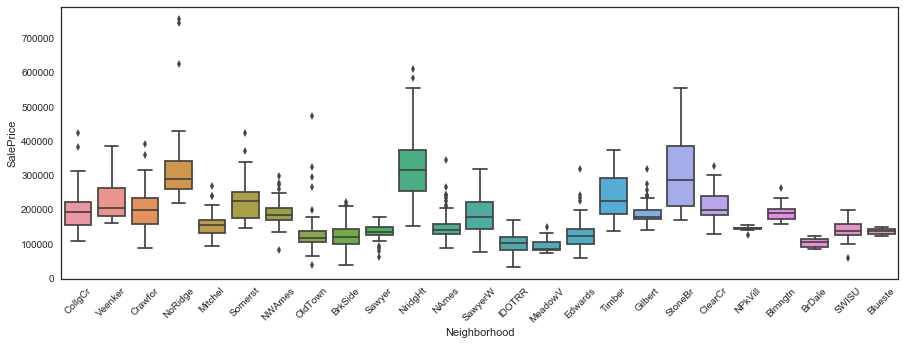

In [341]:
plt.figure(figsize=(15,5))
plt.xticks(rotation='45')
sns.boxplot(x="Neighborhood", y="SalePrice", data=houseDataDF)

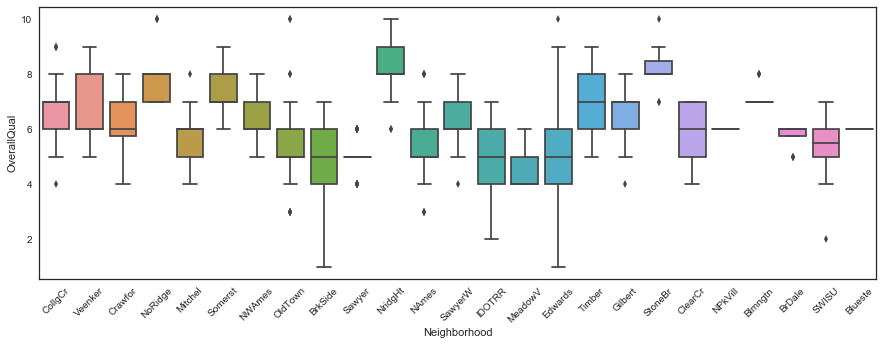

In [342]:
plt.figure(figsize=(15,5))
plt.xticks(rotation='45')
sns.boxplot(x='Neighborhood',
               y='OverallQual', 
               data=houseDataDF)

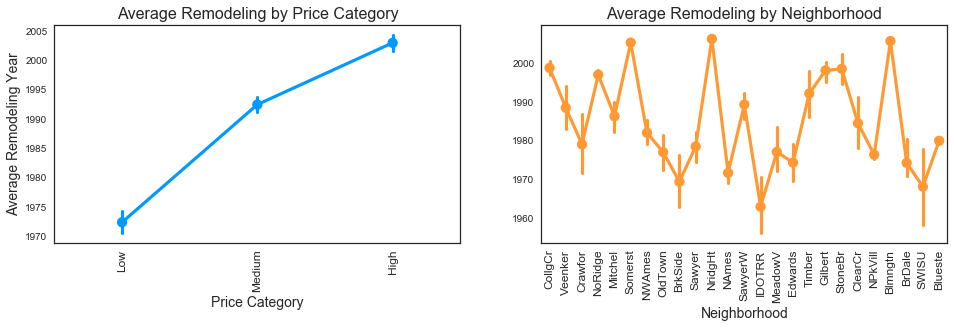

In [343]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
plt.subplot(121)
sns.pointplot(x="Price_Range",  y="YearRemodAdd", data=houseDataDF, order=["Low", "Medium", "High"], color="#0099ff")
plt.title("Average Remodeling by Price Category", fontsize=16)
plt.xlabel('Price Category', fontsize=14)
plt.ylabel('Average Remodeling Year', fontsize=14)
plt.xticks(rotation=90, fontsize=12)

plt.subplot(122)
sns.pointplot(x="Neighborhood",  y="YearRemodAdd", data=houseDataDF, color="#ff9933")
plt.title("Average Remodeling by Neighborhood", fontsize=16)
plt.xlabel('Neighborhood', fontsize=14)
plt.ylabel('')
plt.xticks(rotation=90, fontsize=12)
plt.show()

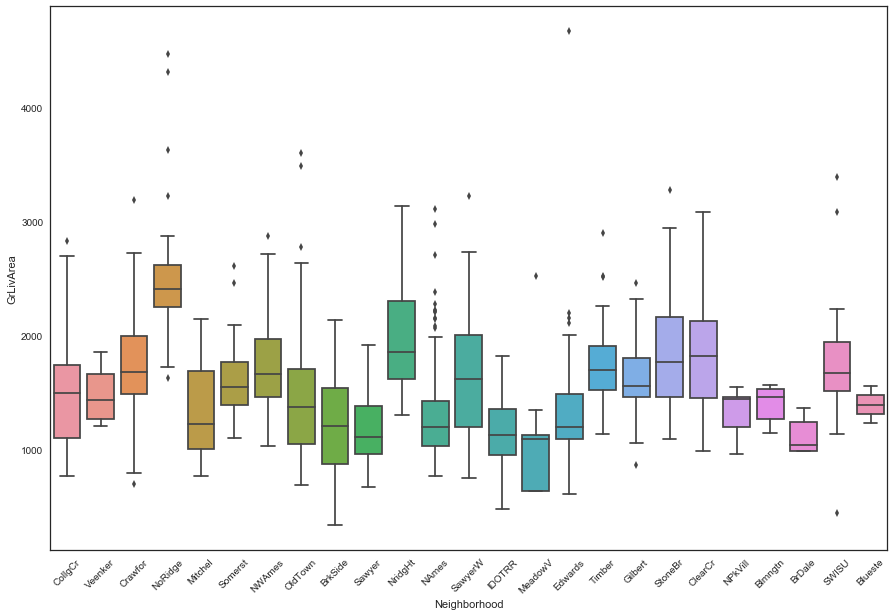

In [344]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='45')
sns.boxplot(x='Neighborhood',
               y='GrLivArea', 
               data=houseDataDF)

### Time related features

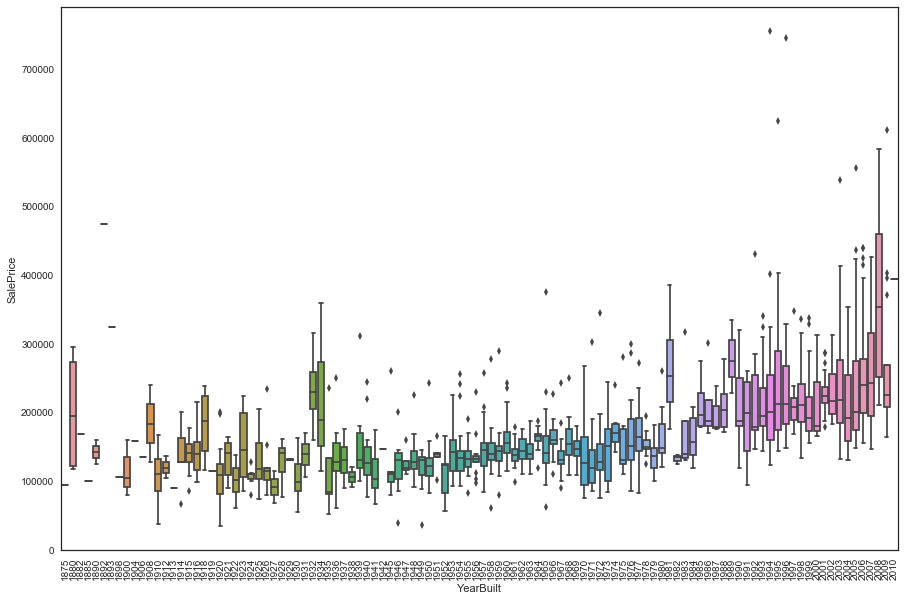

In [345]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
ax = sns.boxplot(x='YearBuilt',
               y='SalePrice', 
               data=houseDataDF)

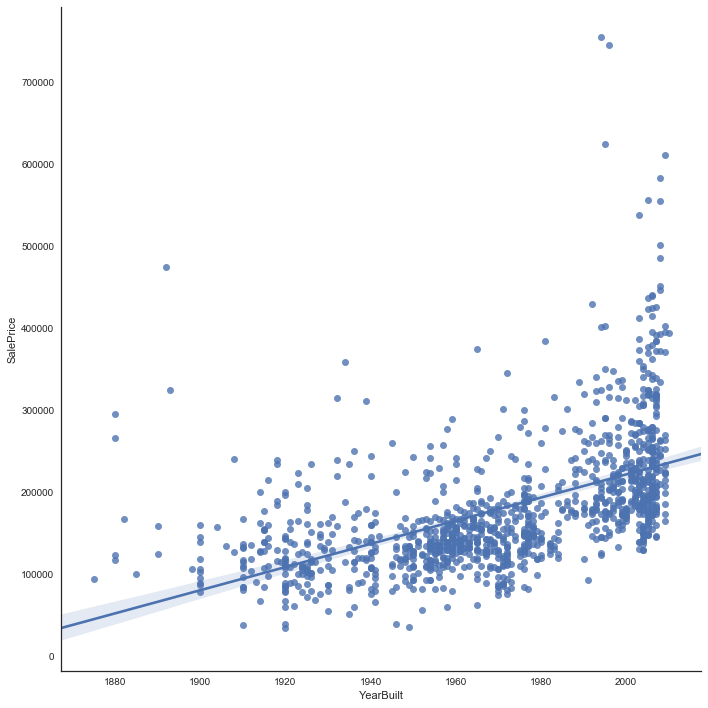

In [346]:
h = sns.lmplot(x="YearBuilt",y="SalePrice",data=houseDataDF,fit_reg=True,size=10) 

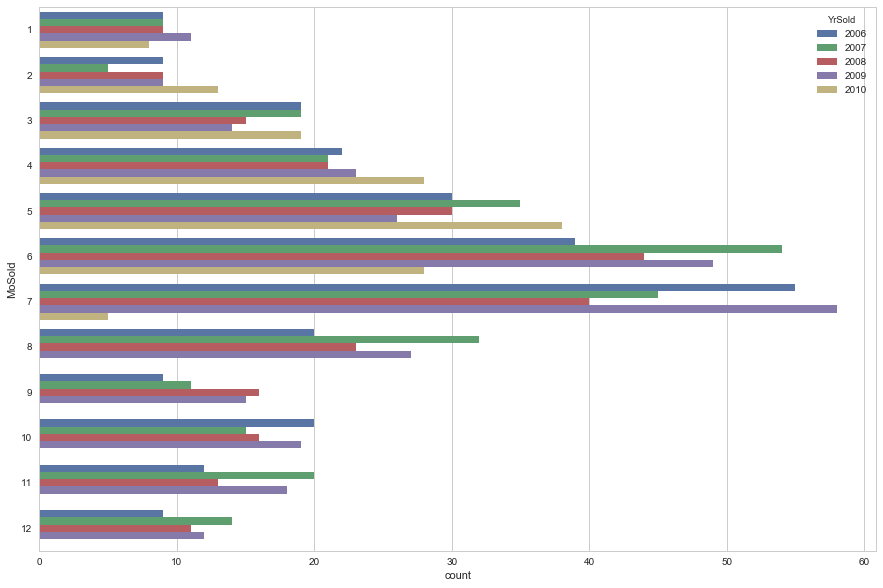

In [347]:
sns.set(style="whitegrid")
plt.figure(figsize=(15,10))
sns.countplot(y="MoSold", hue="YrSold", data=houseDataDF)
plt.show()

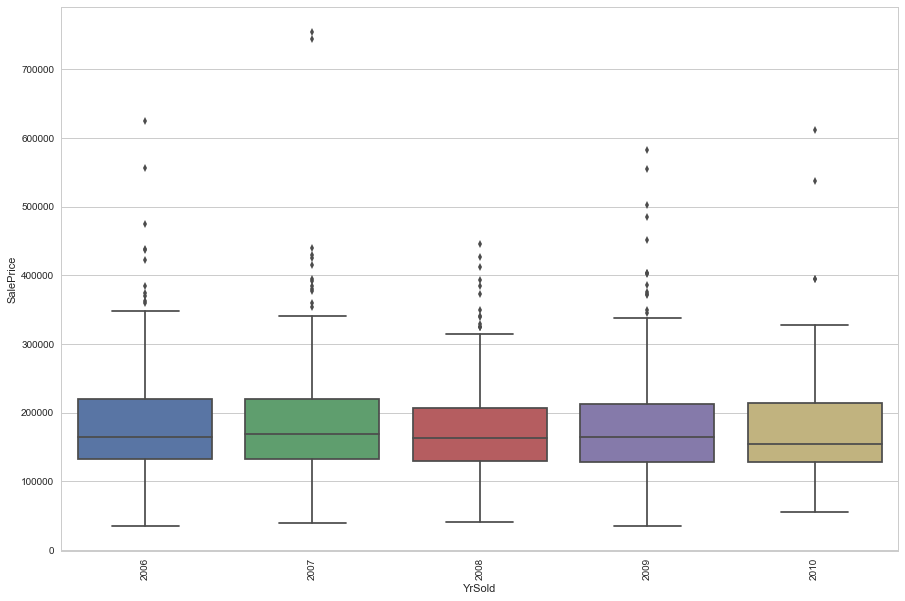

In [348]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.boxplot(x='YrSold',
               y='SalePrice', 
               data=houseDataDF)

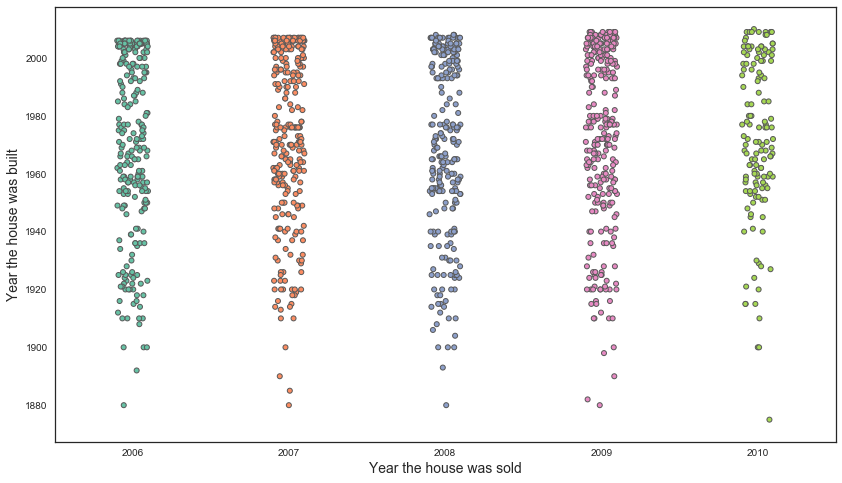

In [349]:
plt.figure(figsize=(14,8))
plt.style.use('seaborn-white')
sns.stripplot(x='YrSold', y='YearBuilt', data=houseDataDF, jitter=True, palette="Set2", linewidth=1)
plt.xlabel('Year the house was sold', fontsize=14)
plt.ylabel('Year the house was built', rotation=90, fontsize=14)
plt.show()

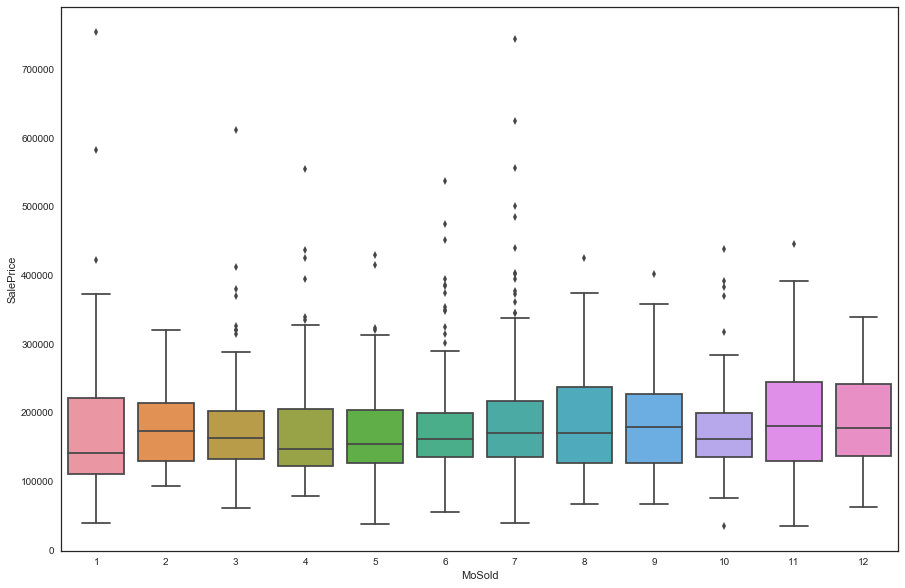

In [350]:
plt.figure(figsize=(15,10))
sns.boxplot(x='MoSold',
               y='SalePrice', 
               data=houseDataDF)

### Categorical features

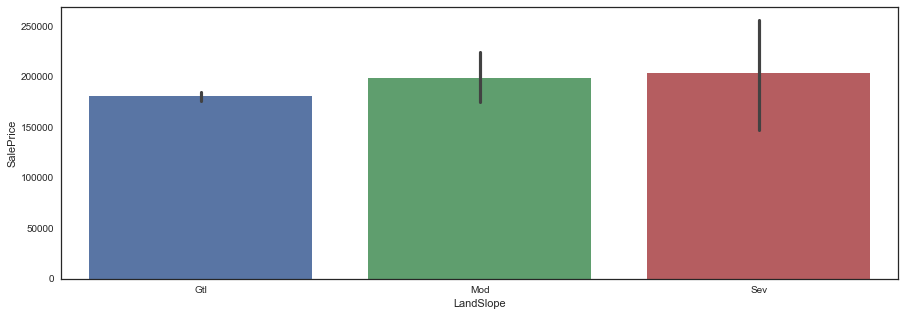

In [351]:
plt.figure(figsize=(15,5))
sns.barplot(x="LandSlope", y="SalePrice", data=houseDataDF)

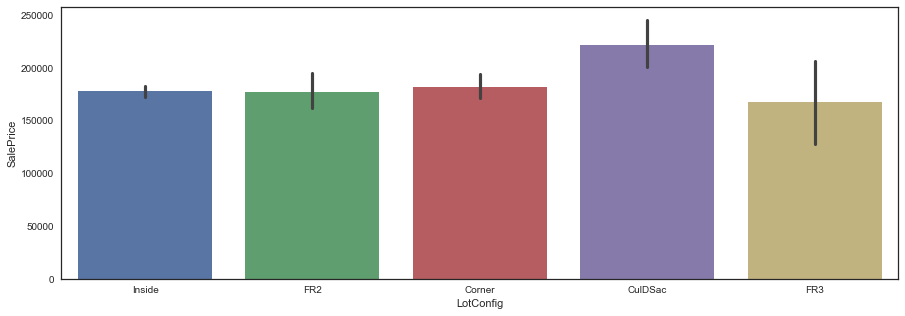

In [352]:
plt.figure(figsize=(15,5))
sns.barplot(x="LotConfig", y="SalePrice", data=houseDataDF)

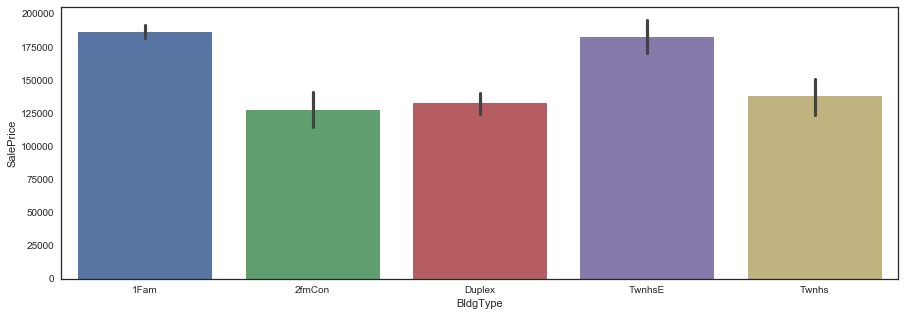

In [353]:
plt.figure(figsize=(15,5))
sns.barplot(x="BldgType", y="SalePrice", data=houseDataDF)

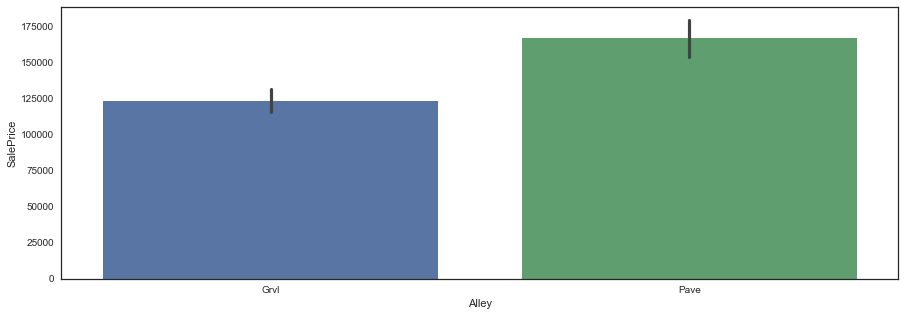

In [354]:
plt.figure(figsize=(15,5))
sns.barplot(x="Alley", y="SalePrice", data=houseDataDF)

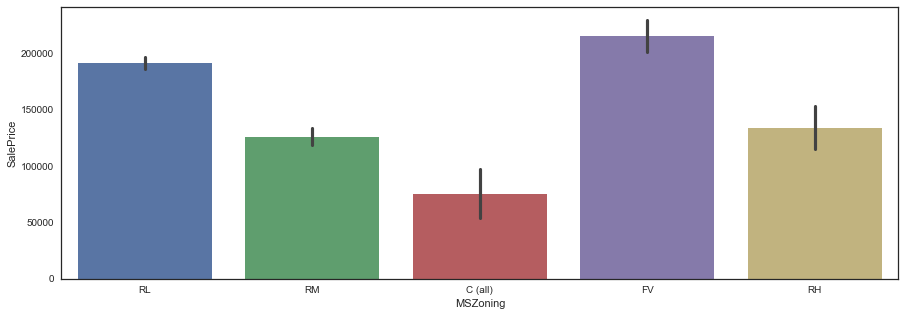

In [355]:
plt.figure(figsize=(15,5))
sns.barplot(x="MSZoning", y="SalePrice", data=houseDataDF)

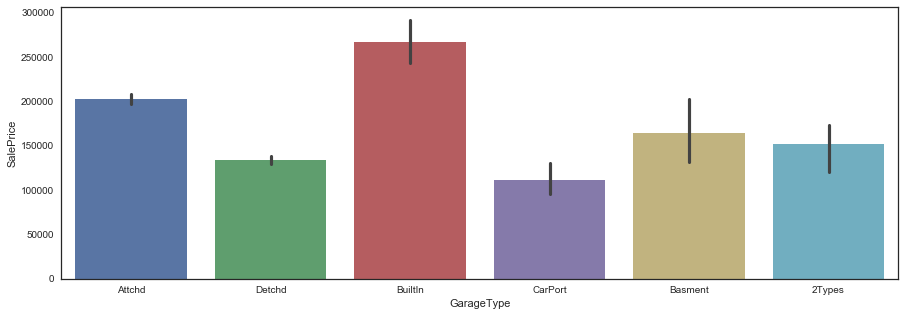

In [356]:
plt.figure(figsize=(15,5))
sns.barplot(x="GarageType", y="SalePrice", data=houseDataDF)

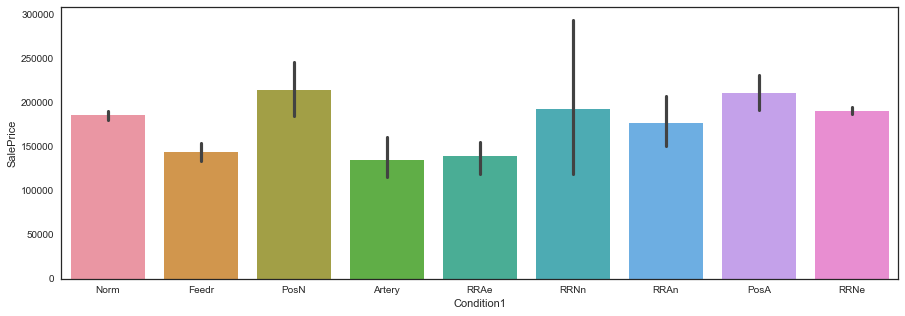

In [357]:
plt.figure(figsize=(15,5))
sns.barplot(x="Condition1", y="SalePrice", data=houseDataDF)

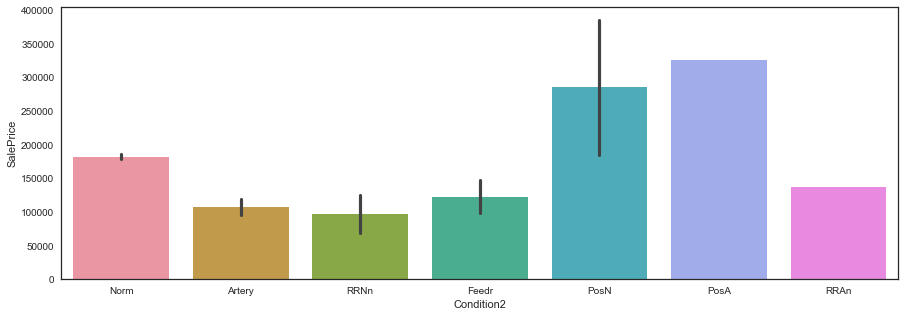

In [358]:
plt.figure(figsize=(15,5))
sns.barplot(x="Condition2", y="SalePrice", data=houseDataDF)

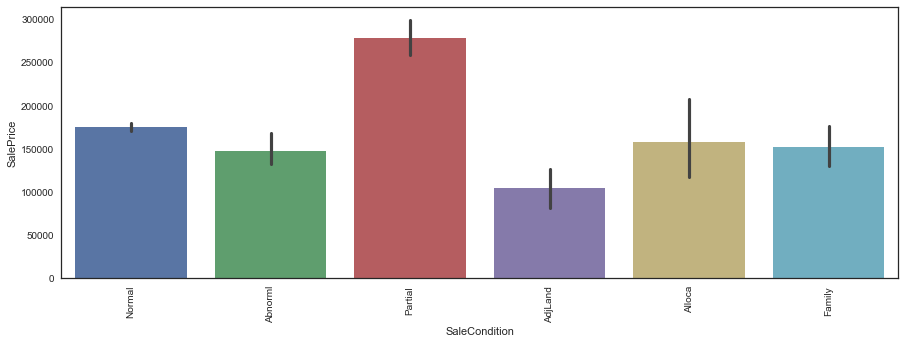

In [359]:
plt.figure(figsize=(15,5))
plt.xticks(rotation='90')
sns.barplot(x="SaleCondition", y="SalePrice", data=houseDataDF)

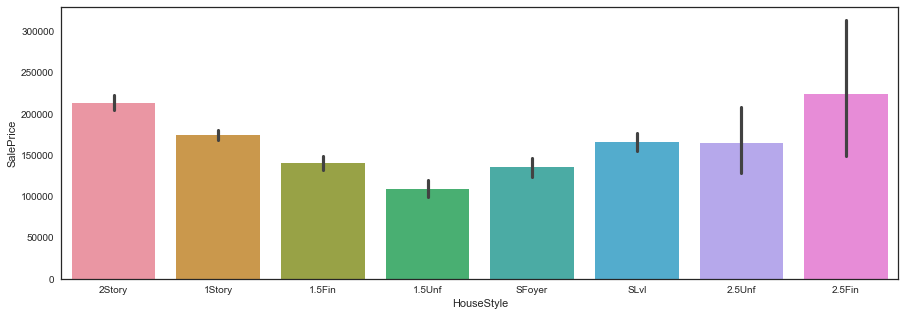

In [360]:
plt.figure(figsize=(15,5))
sns.barplot(x="HouseStyle", y="SalePrice", data=houseDataDF)

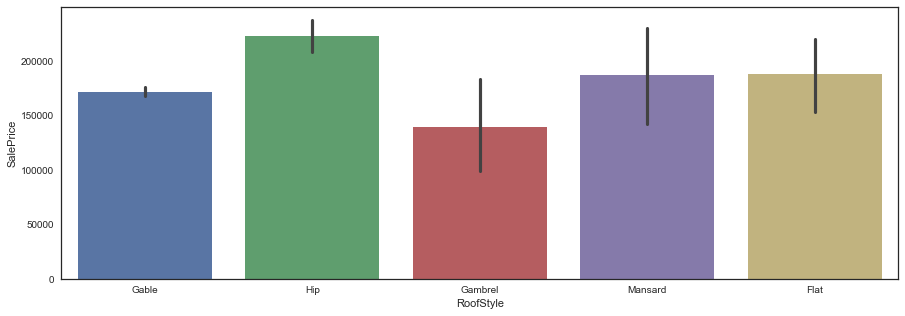

In [361]:
plt.figure(figsize=(15,5))
sns.barplot(x="RoofStyle", y="SalePrice", data=houseDataDF)

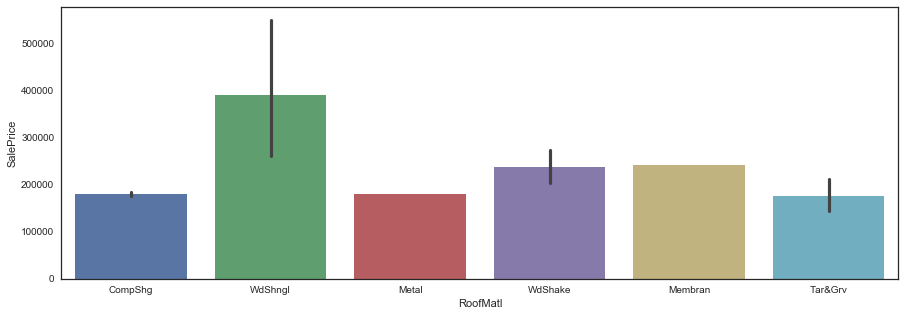

In [362]:
plt.figure(figsize=(15,5))
sns.barplot(x="RoofMatl", y="SalePrice", data=houseDataDF)

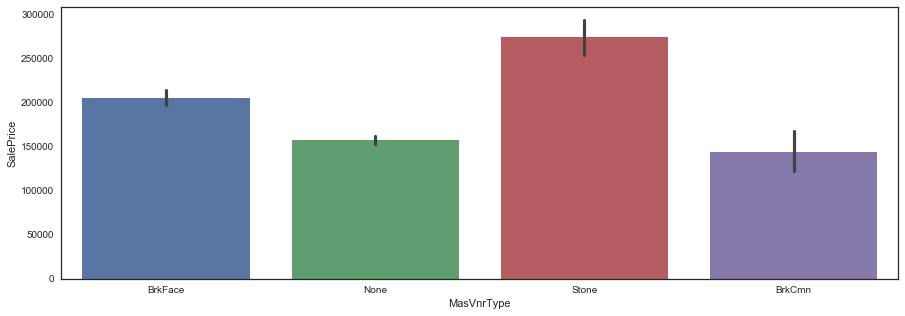

In [363]:
plt.figure(figsize=(15,5))
sns.barplot(x="MasVnrType", y="SalePrice", data=houseDataDF)

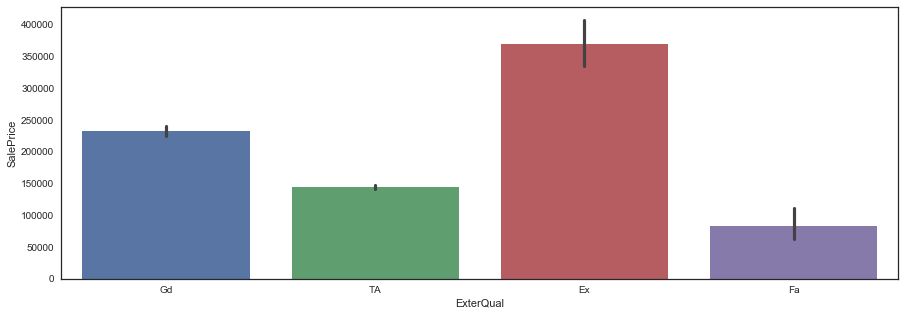

In [364]:
plt.figure(figsize=(15,5))
sns.barplot(x="ExterQual", y="SalePrice", data=houseDataDF)

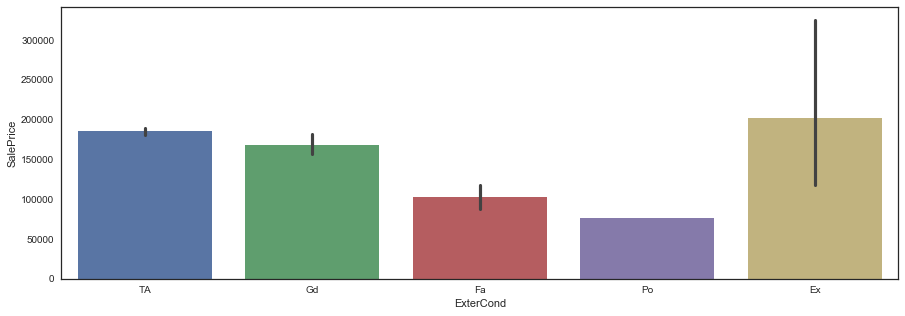

In [365]:
plt.figure(figsize=(15,5))
sns.barplot(x="ExterCond", y="SalePrice", data=houseDataDF)

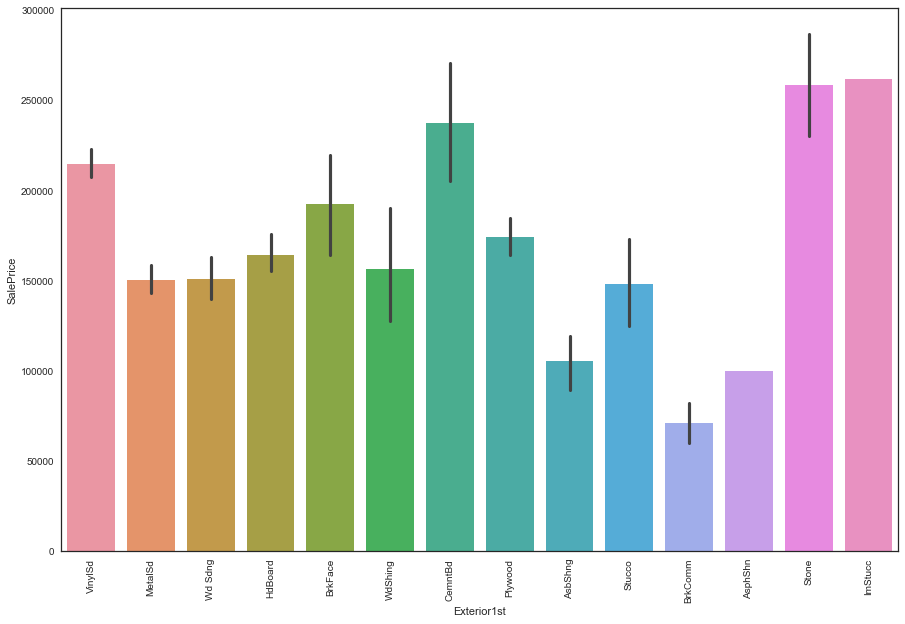

In [366]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Exterior1st", y="SalePrice", data=houseDataDF)

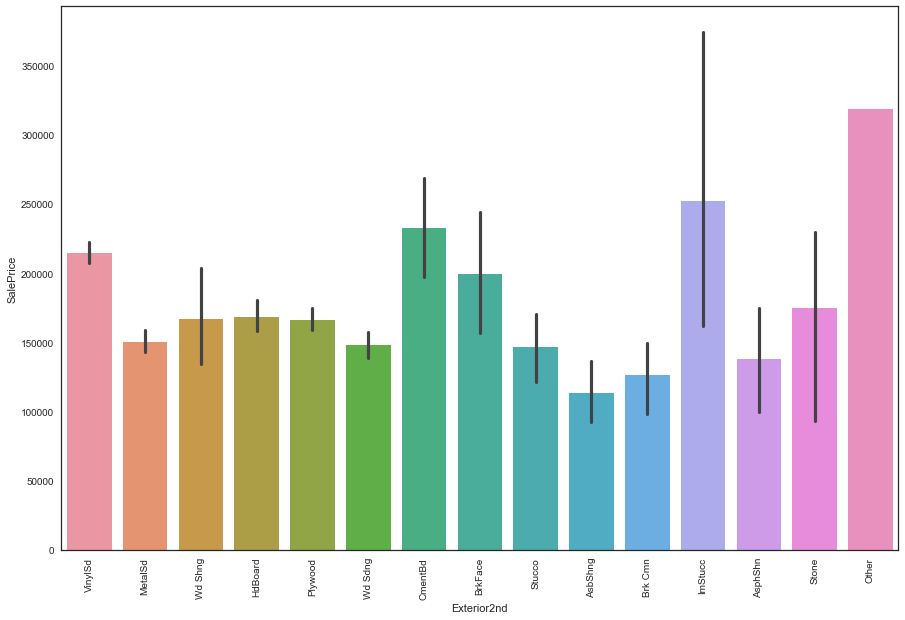

In [367]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Exterior2nd", y="SalePrice", data=houseDataDF)

In [368]:
houseDataDF = houseDataDF.drop(["Price_Range"],axis=1)

# Cleaning the data

## Removing outliers

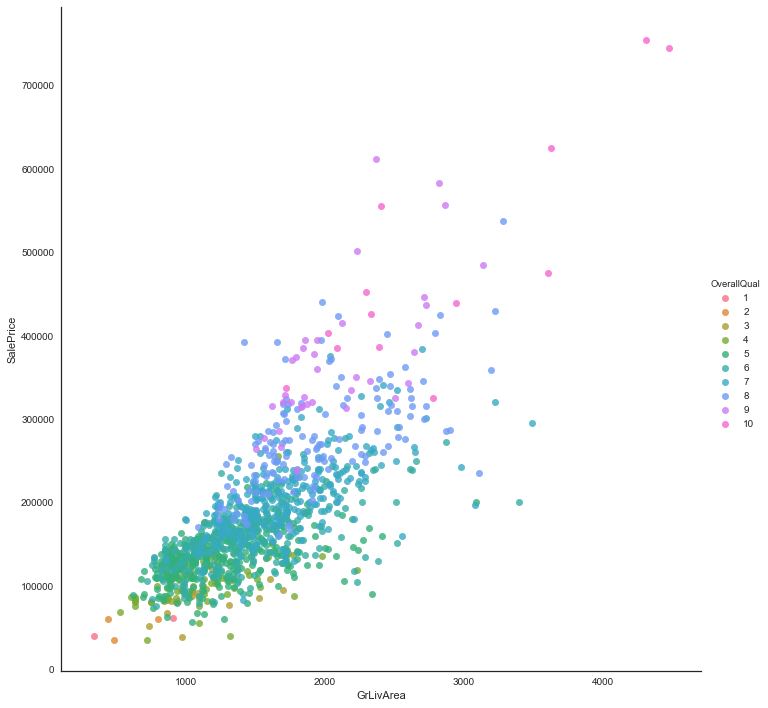

In [369]:
houseDataCleanedDF = houseDataDF.drop(outliers)
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataCleanedDF,fit_reg=False,size=10,hue="OverallQual")

## Feature engineering

In [370]:
y = np.log(houseDataCleanedDF.SalePrice)
houseDataCleanedDF = houseDataCleanedDF.drop(["SalePrice"],axis=1)
houseDataCleanedDF = pd.concat([houseDataCleanedDF,testDF])

In [371]:
def transformCategoricalFeatures(houseDataDF):
    categorical_feats = houseDataDF.dtypes[houseDataDF.dtypes == "object"].index.values

    for feat in categorical_feats:
        if(feat == "Utilities" or feat == "Alley"):
            continue
            
        dummies = pd.get_dummies(houseDataDF[feat], drop_first=True)
        num_categories = len(dummies.columns)
        houseDataDF[[feat+str(i) for i in range(num_categories)]] = dummies
    
    return houseDataDF
        
    
def makeNewFeatures(houseDataDF):

    # CUSTOM FEATURES
    houseDataDF['NearPark'] = [1 if x=='PosN' or x=='PosA' or y=='PosN' or y=='PosA' else 0\
        for x,y in zip(houseDataDF['Condition1'],houseDataDF['Condition2'])]

    houseDataDF['Loudness'] = [1 if x=='Feedr' or x=='Artery' or x=='RRAe' or y=='Feedr'\
        or y=='Artery' or y=='RRAe' else 0 for x,y in zip(houseDataDF['Condition1'],houseDataDF['Condition2'])]
    
    houseDataDF['TotalSF'] = houseDataDF['TotalBsmtSF'] + houseDataDF['1stFlrSF'] + houseDataDF['2ndFlrSF']
    
    houseDataDF['TimeBetweenRemodAndBuild'] =  [x-y for x,y in zip(houseDataDF["YearRemodAdd"],houseDataDF["YearBuilt"])]
    
    houseDataDF['RemodeledResent'] =  [1 if x != y and 2010 - x < 10 else 0 for x,y in zip(houseDataDF["YearRemodAdd"],houseDataDF["YearBuilt"])]
    
    houseDataDF['Age'] =  [2010 - x for x in houseDataDF["YearBuilt"]]
    
    houseDataDF['AvgQualCond'] =  [(int(x)+int(y))/2 for x,y in zip(houseDataDF["OverallQual"],houseDataDF["OverallCond"])]
    
    houseDataDF['TotalPorchSF'] = houseDataDF['OpenPorchSF'] + houseDataDF['EnclosedPorch'] + houseDataDF['3SsnPorch'] + houseDataDF['ScreenPorch']
    
    houseDataDF['OverallQualSquared'] = [x**2 for x in houseDataDF["OverallQual"]]
    
    houseDataDF['OverallCondSquared'] = [x**2 for x in houseDataDF["OverallCond"]]
    
    houseDataDF['avgQualCondSquared'] = [x**2 for x in houseDataDF["AvgQualCond"]]
    
    houseDataDF['SoldDuringFinancialCrysis'] = [1 if x == 2008 else 0 for x in houseDataDF["YrSold"]]
    
    houseDataDF['NoGarage'] = [1 if x == 0 else 0 for x in houseDataDF["GarageArea"]]
    
    return houseDataDF
    
houseDataCleanedDF = transformCategoricalFeatures(houseDataCleanedDF)
houseDataCleanedDF = makeNewFeatures(houseDataCleanedDF)
# TODO : Add feature for centrality

/home/marius/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


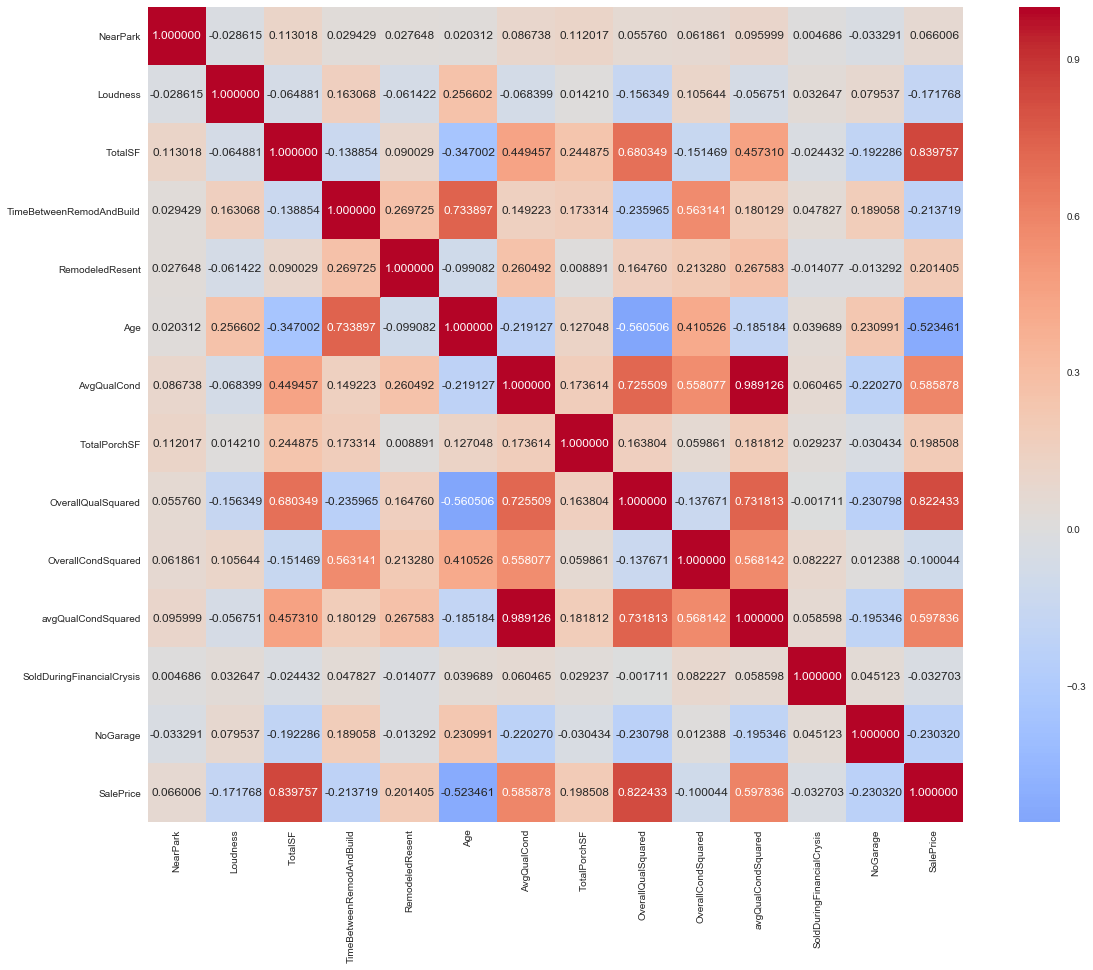

In [372]:
customFeatures = ['NearPark','Loudness','TotalSF','TimeBetweenRemodAndBuild','RemodeledResent',\
                  'Age','AvgQualCond','TotalPorchSF','OverallQualSquared','OverallCondSquared',\
                  'avgQualCondSquared','SoldDuringFinancialCrysis','NoGarage']

plt.figure(figsize=(20,15))
customFeaturesDF = houseDataCleanedDF[customFeatures]
customFeaturesDF["SalePrice"] = np.exp(y)
corr = customFeaturesDF.corr()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            square=True, center=0,cmap='coolwarm',
            annot=True, fmt="f"
           )

## Fixing skew

In [373]:
def fixSkew(houseDataDF,verbose=0):
    numeric_feats = houseDataDF.dtypes[houseDataDF.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = houseDataDF[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 0.75]
    
    if verbose != 0:
        print("\nSkew in numerical features: \n")
        print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))


    skewed_features = skewness.index

    lam = 0.15
    
    for feat in skewed_features:
        #all_data[feat] += 1
        if(feat not in ["SalePrice","YearBuilt","HousePriceIndex","Vacency","USBonds"]):#,"HousePriceIndex","Vacency","USBonds"]):
            houseDataDF[feat] = boxcox1p(houseDataDF[feat], lam)
    return houseDataDF

houseDataCleanedDF = fixSkew(houseDataCleanedDF)

# Predictions

https://datascienceplus.com/linear-regression-in-python-predict-the-bay-areas-home-prices/
https://www.kaggle.com/dougdaly/house-price-modeling-with-random-forest-regressors
https://shankarmsy.github.io/stories/gbrt-sklearn.html
https://www.kaggle.com/nolberg/machine-learning-for-house-price-prediction
https://kaggle2.blob.core.windows.net/forum-message-attachments/216792/7200/MDSSKaggle_Slides_Henry.pdf
https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
https://www.kaggle.com/jimthompson/ensemble-model-stacked-model-example
https://www.kaggle.com/janiobachmann/in-depth-analysis-house-prices-ensembling
https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5/notebook
https://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/
https://stats.stackexchange.com/questions/139042/ensemble-of-different-kinds-of-regressors-using-scikit-learn-or-any-other-pytho?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

In [374]:
data = houseDataCleanedDF.select_dtypes(include=[np.number]).interpolate().dropna()
drop_cols = ["YearBuilt",'YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'TotalBsmtSF', 'BsmtFinSF1']
data = data.drop(drop_cols,axis=1)

columns = data.columns.values

currentTrainSetLenght = trainSetLength - len(outliers)

trainData = pd.DataFrame(data=data.values[:currentTrainSetLenght],columns=columns)

testData = pd.DataFrame(data=data.values[currentTrainSetLenght:],columns=columns)



In [375]:
X = trainData
training_features = X.columns.values

In [376]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.2)

## Linear Regression

In [377]:
lr = LinearRegression()
linearModel = lr.fit(X_train,y_train)
print ("R^2 is:", linearModel.score(X_test, y_test))

R^2 is: 0.8579736752196758


In [378]:
predictions = linearModel.predict(X_test)

print ('MSE is:', mean_squared_error(y_test, predictions))

MSE is: 0.02188097225024344


In [379]:
scores = cross_val_score(linearModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -1.89 (+/- 6.16)


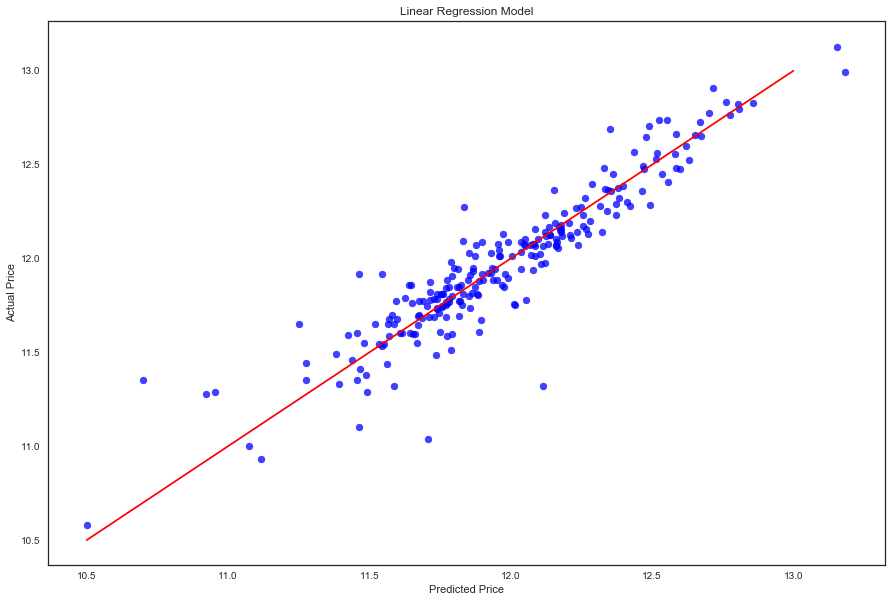

In [380]:

actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

### KernelRidge Regularization

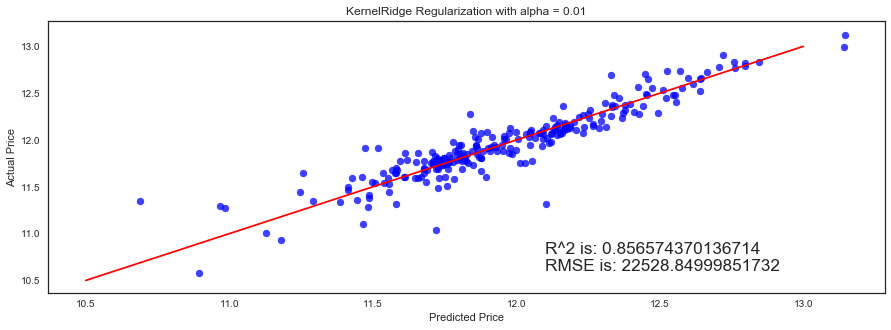

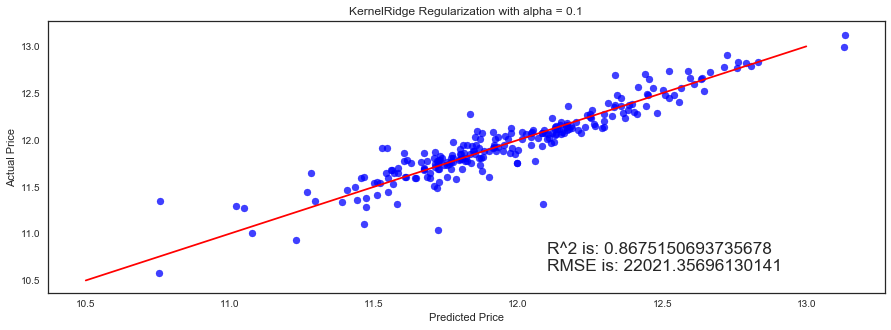

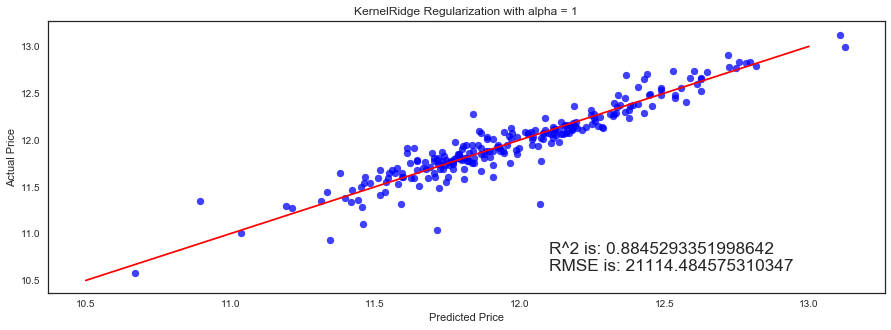

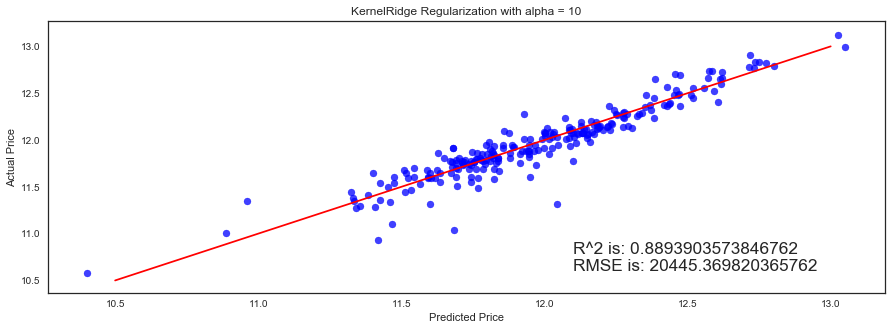

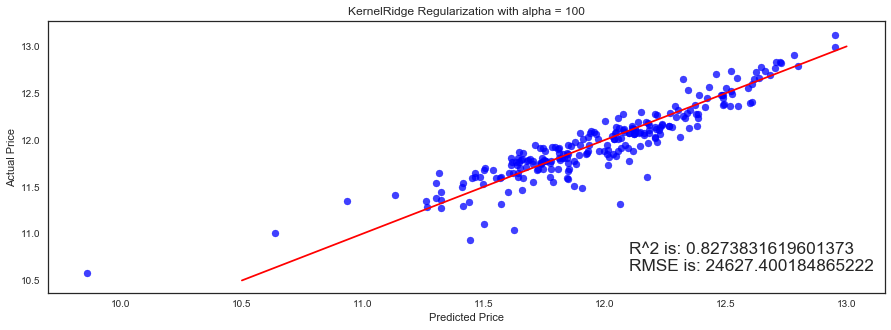

In [381]:
for alpha in [0.01,0.1,1,10,100]:
    rm = KernelRidge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)
    plt.figure(figsize=(15,5))
    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.plot([10.5,13],[10.5,13],"r")
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('KernelRidge Regularization with alpha = {}'.format(alpha))
    rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(preds_ridge)))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    ridge_model.score(X_test, y_test),
                    rmse)
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()


## BayesianRidge

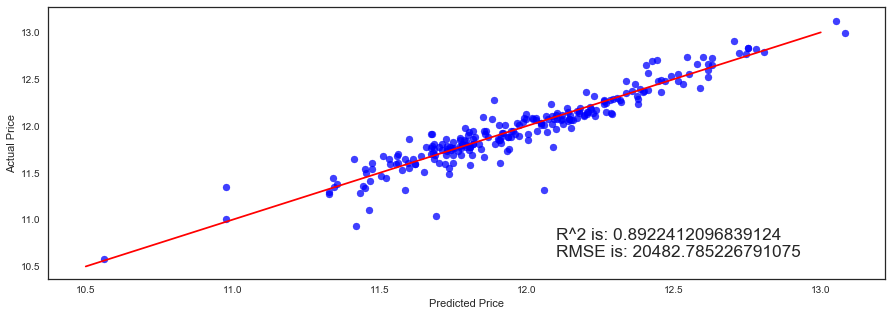

In [382]:

br = BayesianRidge(alpha_1=1e-08,alpha_2=5e-06)
bayesian_model = br.fit(X_train, y_train)
br_preds = bayesian_model.predict(X_test)
plt.figure(figsize=(15,5))
plt.scatter(br_preds, actual_values, alpha=.75, color='b')
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(br_preds)))

overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                bayesian_model.score(X_test, y_test),
                rmse)

plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()


## Random Forrest

In [383]:
fr = RandomForestRegressor(n_estimators=100,random_state=42)
randomForrestModel = fr.fit(X_train, y_train)
print ("R^2 is:", randomForrestModel.score(X_test, y_test))

R^2 is: 0.8664516362397874


In [384]:
fr_preds = randomForrestModel.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(fr_preds)))
print ('RMSE is:', rmse)

RMSE is: 23598.288963209765


In [385]:
scores = cross_val_score(randomForrestModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.19)


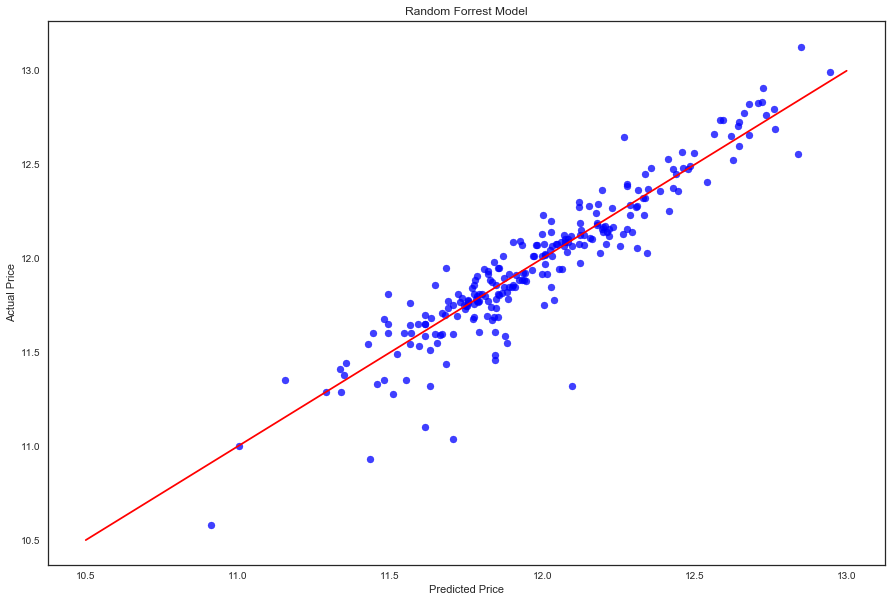

In [386]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(fr_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Random Forrest Model')
plt.show()

## Support Vector Regressor

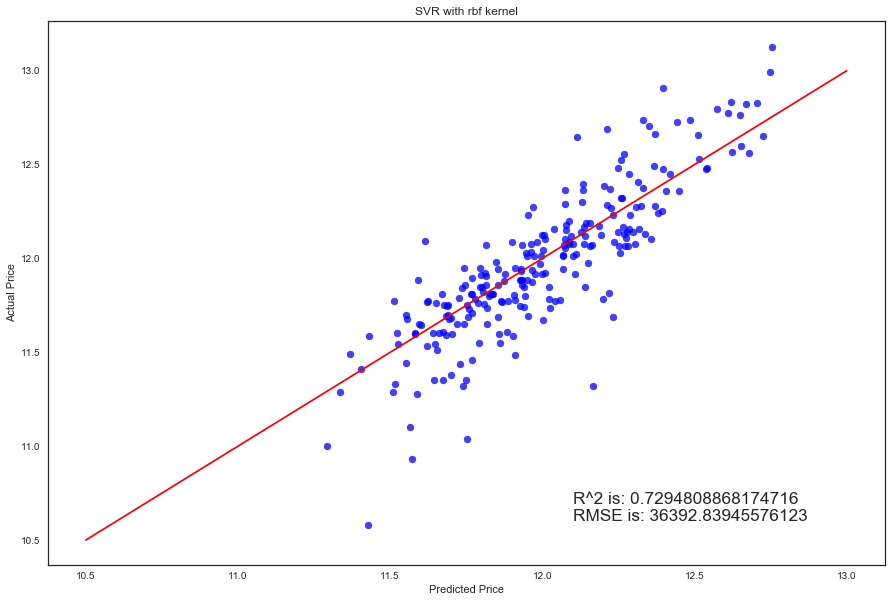

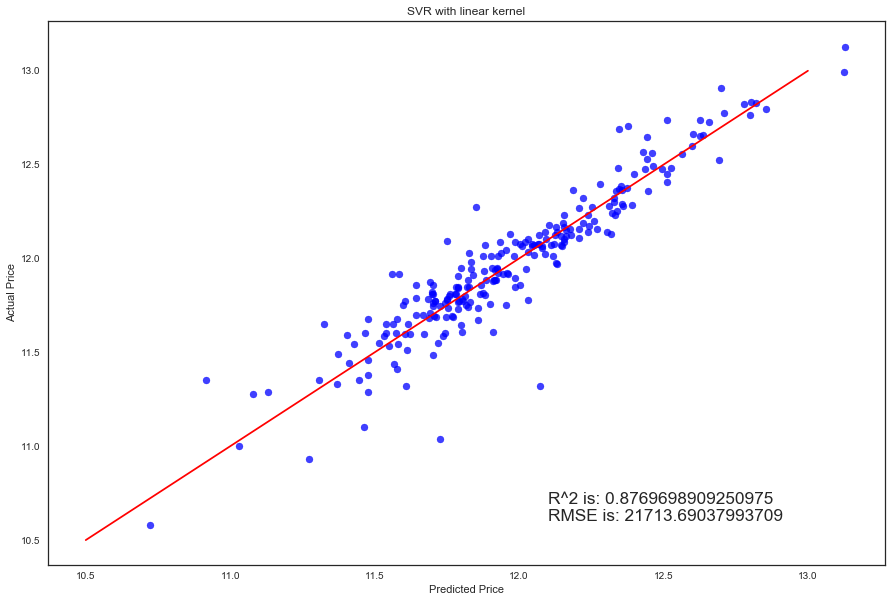

In [387]:
svr_rbf = SVR(kernel='rbf')
svr_lin = SVR(kernel='linear')
svr_rbf_model = svr_rbf.fit(X_train, y_train)
svr_lin_model = svr_lin.fit(X_train, y_train)
rbf_preds = svr_rbf_model.predict(X_test)
lin_preds = svr_lin_model.predict(X_test)
rbf_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(rbf_preds)))
lin_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(lin_preds)))

plt.figure(figsize=(15,10))
plt.scatter(rbf_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SVR with rbf kernel')
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                svr_rbf_model.score(X_test, y_test),
                rbf_rmse)
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()

plt.figure(figsize=(15,10))
plt.scatter(lin_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SVR with linear kernel')
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                svr_lin_model.score(X_test, y_test),
                lin_rmse)
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()


## Gradient boosting

In [388]:
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2)


In [389]:
def hyperparameterTuning(estimator,param_grid,cv,n_jobs=4): 
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs,verbose=1)
    classifier.fit(X_train, y_train)
    print("Best Estimator learned through GridSearch")
    print(classifier.best_estimator_)
    return classifier.best_estimator_

In [390]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(15,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

R^2 is: 0.8758714179943927


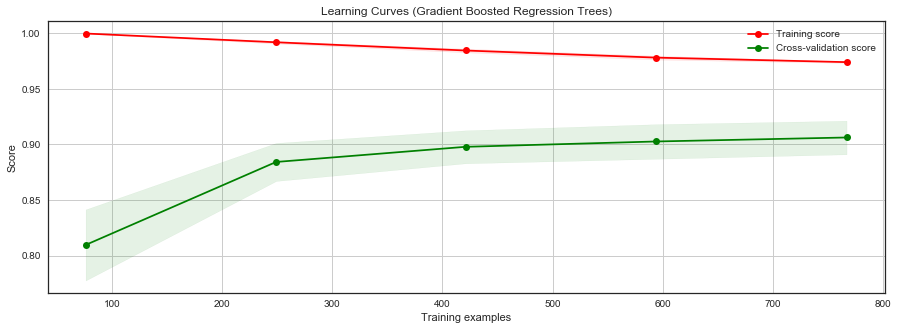

In [391]:
gb = GradientBoostingRegressor()
title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(gb, title, X_train, y_train, cv=cv, n_jobs=4)
gradientBoostingModel = gb.fit(X_train, y_train)
print ("R^2 is:", gradientBoostingModel.score(X_test, y_test))

In [392]:
predictions = gradientBoostingModel.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predictions)))
print ('RMSE is:', rmse)

RMSE is: 20835.05910421802


In [393]:
scores = cross_val_score(gradientBoostingModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.16)


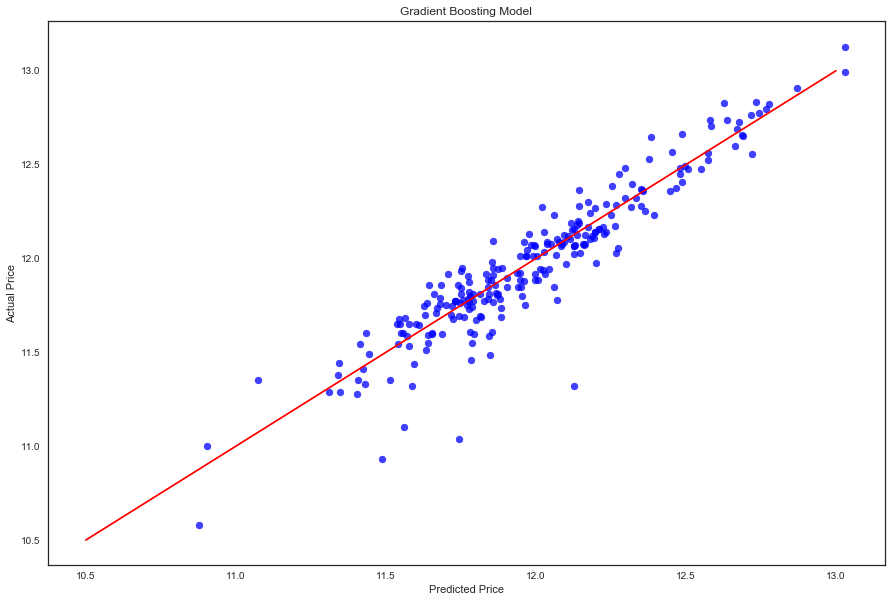

In [394]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Gradient Boosting Model')
plt.show()

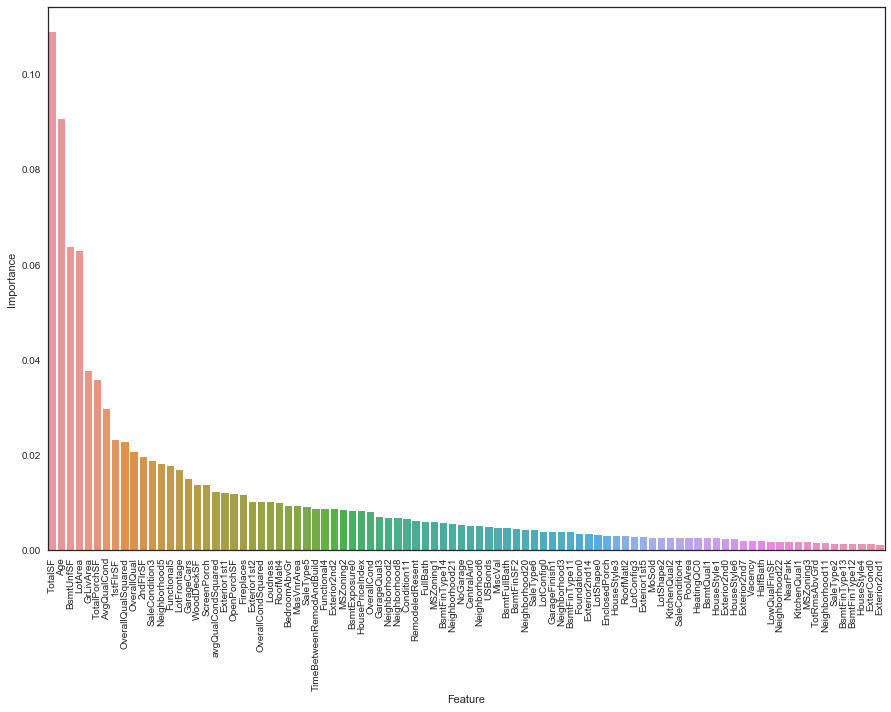

In [395]:
importances = gb.feature_importances_
columns = X_test.columns.values


feature_importance = list(zip(columns,importances))
sorted_feature_importance = np.array(sorted(feature_importance,key=lambda x : x[1],reverse=True))
sorted_feature_importance = list(map(lambda x : [x[0],float(x[1])],sorted_feature_importance))


featureImportanceDF = pd.DataFrame(data=sorted_feature_importance,columns=["Feature","Importance"]).query("Importance > 0.001")
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Feature", y="Importance",data=featureImportanceDF)


### Improving Gradient Boosting

In [396]:
param_grid={'n_estimators':[100],
            'learning_rate': [0.1],
            'max_depth':[6],
            'min_samples_leaf':[3],
            'max_features':[1.0],
           }

estimator = GradientBoostingRegressor()
best_est = hyperparameterTuning(estimator,param_grid,cv)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    6.9s finished


Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=1.0,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


<module 'matplotlib.pyplot' from '/home/marius/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

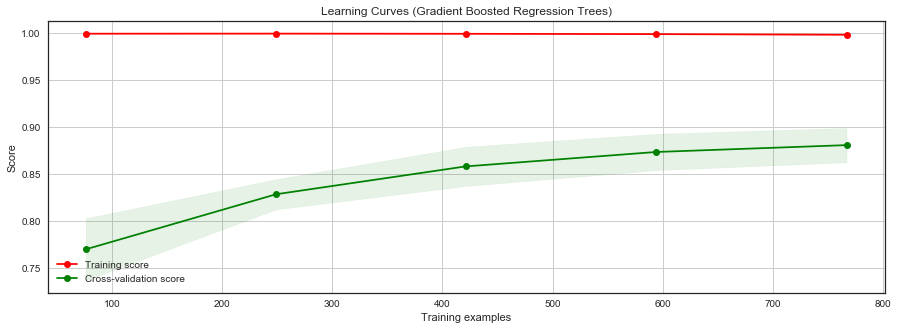

In [397]:
model_gb = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
            learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
            max_features=best_est.max_features)
title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(model_gb, title, X_train, y_train, cv=cv, n_jobs=4)

In [398]:
model_gb.fit(X_train, y_train)
predictions = model_gb.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predictions)))
print ('RMSE is:', rmse)

RMSE is: 22259.02213833631


In [399]:
param_grid={'n_estimators':[100,500,1000,2000],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6],
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1]
           }

#cv,best_est=GradientBooster(param_grid, n_jobs)

try:
    best_est = pickle.load( open( "GradientBoostingBestEstimator.p", "rb" ) )
    None
except:
    model_gb = GradientBoostingRegressor()
    best_est = hyperparameterTuning(model_gb,param_grid,cv)
    None



In [400]:
pickle.dump(best_est, open( "GradientBoostingBestEstimator.p", "wb" ) )

<module 'matplotlib.pyplot' from '/home/marius/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

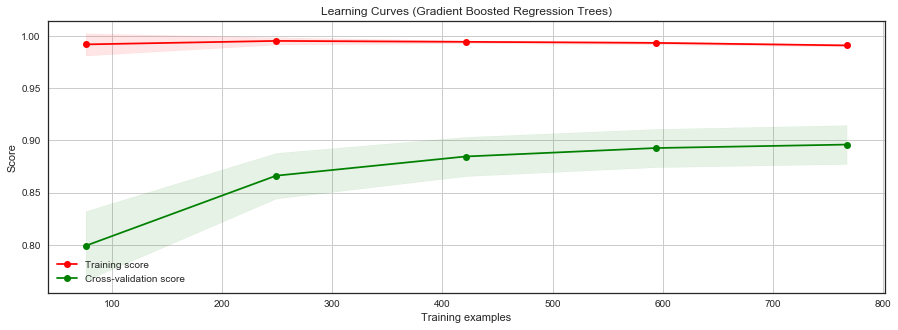

In [401]:
model_gb = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
            learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
            max_features=best_est.max_features,loss="huber",random_state=5)

title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(model_gb, title, X_train, y_train, cv=cv, n_jobs=4)


In [402]:
model_gb.fit(X_train, y_train)
gb_preds = model_gb.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(gb_preds)))
print ("R^2 is:", model_gb.score(X_test, y_test))
print ('RMSE is:', rmse)

R^2 is: 0.8891323925871827
RMSE is: 20105.914414809442


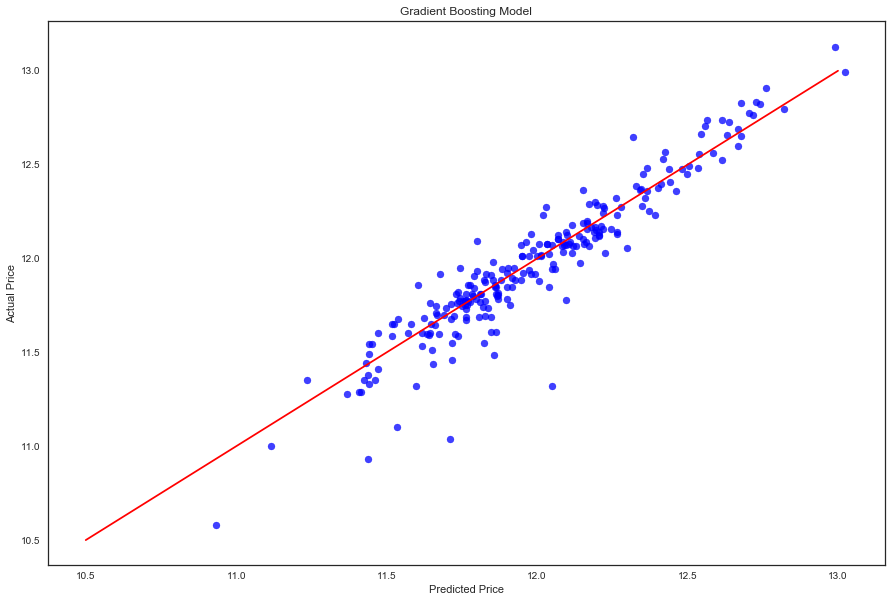

In [403]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(gb_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Gradient Boosting Model')
plt.show()

### Using XGBoost 

In [404]:
param_grid={'learning_rate': [0.05, 0.02, 0.01],
            'max_depth':[4,6,8],
            'gamma':[0.01,0.04,0.08,0.12], 
            'subsample':[0.5,0.75,1],
            'colsample_bytree':[0.5,0.75,1],
            'reg_alpha':[0.001,0.01,0.1],
            'reg_lambda':[0.001,0.01,0.1],
            'n_estimators':[2000,3000]
           }
#model_xgb = xgb.XGBRegressor()
#best_est = hyperparameterTuning(model_xgb,param_grid,cv)
try:
    #best_est = pickle.load( open( "XGBoostBestEstimator.p", "rb" ) )
    None
except:
    #model_xgb = xgb.XGBRegressor()
    #best_est = hyperparameterTuning(model_xgb,param_grid,cv)
    None

In [405]:
pickle.dump(best_est, open( "XGBoostBestEstimator.p", "wb" ) )

In [406]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

title = "Learning Curves (XGBoost Regression Trees)"
#plot_learning_curve(model_xgb, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [407]:
model_xgb.fit(X_train, y_train)
xgb_preds = model_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(xgb_preds)))
print ("R^2 is:", model_xgb.score(X_test, y_test))
print ('RMSE is:', rmse)

R^2 is: 0.8833155226195795
RMSE is: 20840.83149572919


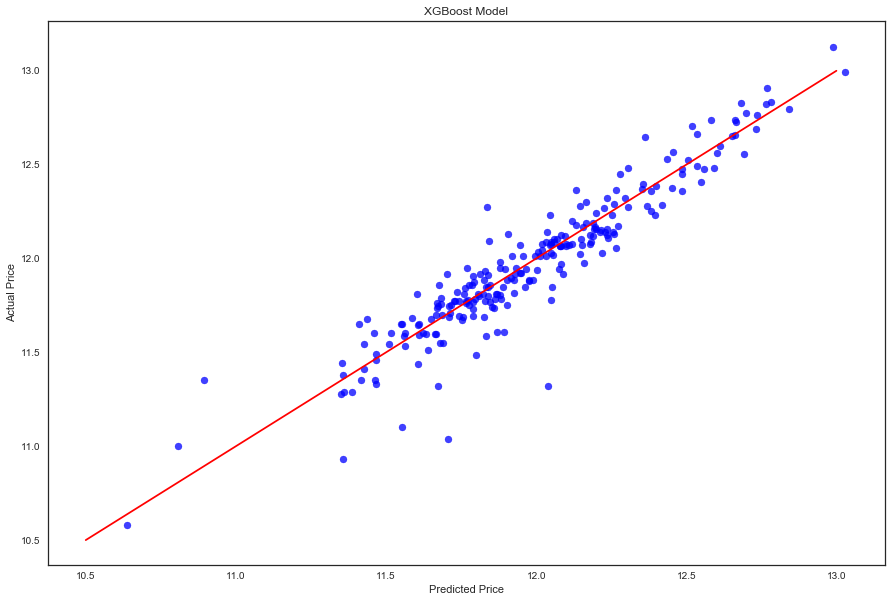

In [408]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(xgb_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBoost Model')
plt.show()

### Using LightGBM

In [409]:
param_grid={'n_estimators':[100,500,1000,2000],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6],
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1]
           }
"""
try:
    best_est = pickle.load( open( "LightGBMBestEstimator.p", "rb" ) )
except:
    model_lgb = lgb.LGBMRegressor()
    best_est = hyperparameterTuning(model_lgb,param_grid,cv)
    None
"""

'\ntry:\n    best_est = pickle.load( open( "LightGBMBestEstimator.p", "rb" ) )\nexcept:\n    model_lgb = lgb.LGBMRegressor()\n    best_est = hyperparameterTuning(model_lgb,param_grid,cv)\n    None\n'

In [410]:
#pickle.dump(best_est, open( "LightGBMBestEstimator.p", "wb" ) )

In [411]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=2200,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
title = "Learning Curves (LightGBM Regression Trees)"
#plot_learning_curve(model_lgb, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [412]:
model_lgb.fit(X_train, y_train)
lgb_preds = model_lgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(lgb_preds)))
print ("R^2 is:", model_lgb.score(X_test, y_test))
print ('RMSE is:', rmse)

R^2 is: 0.8936312467156406
RMSE is: 19911.400014707895


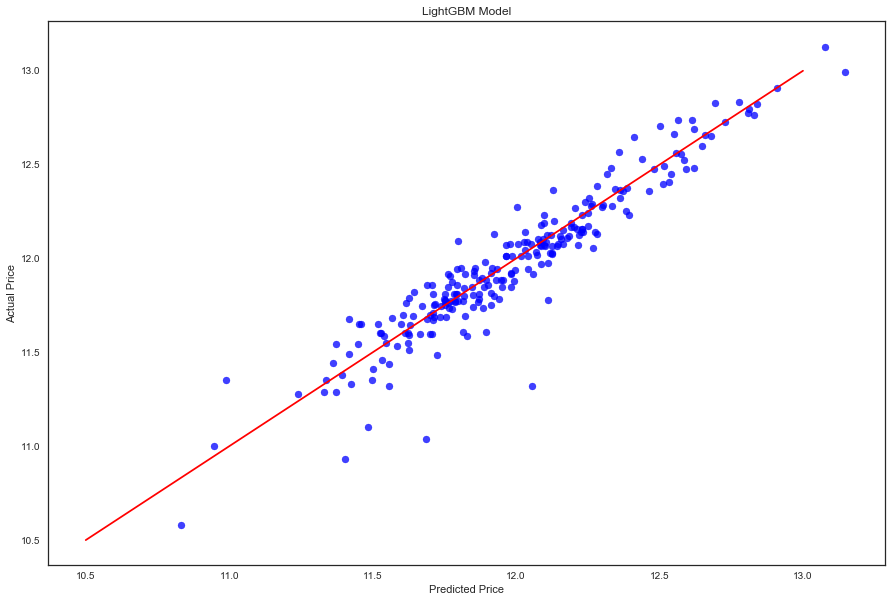

In [413]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(lgb_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('LightGBM Model')
plt.show()

# Using Lasso Regularization as a Meta-model

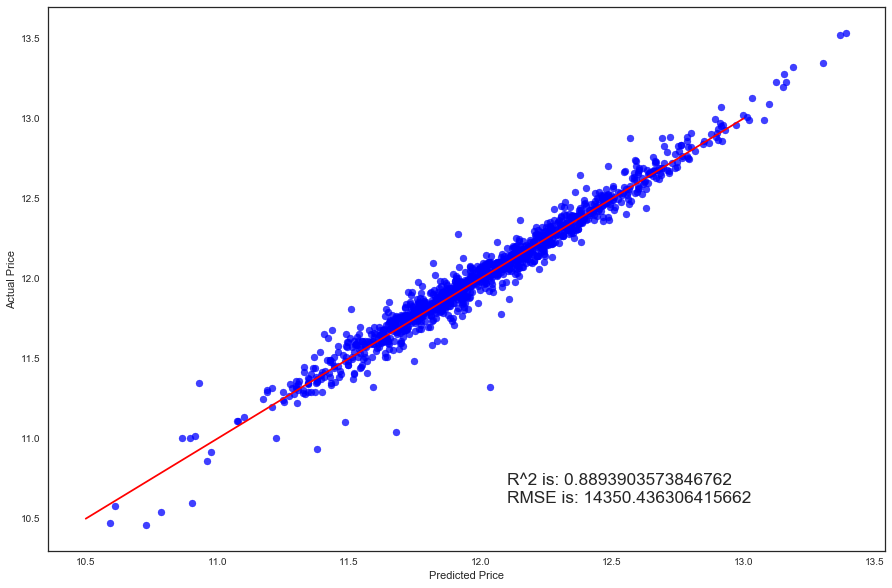

In [414]:
rm = KernelRidge(alpha=10)
ridge_model = rm.fit(X_train, y_train)
rm_preds = ridge_model.predict(X_test)

lgb_test_preds = model_lgb.predict(X)
xgb_test_preds = model_xgb.predict(X)
gb_test_preds = model_gb.predict(X)
rm_test_preds = ridge_model.predict(X)
br_test_preds = bayesian_model.predict(X)
fr_test_preds = randomForrestModel.predict(X)

all_preds = np.array([lgb_preds,rm_preds,xgb_preds,gb_preds]).T
all_test_preds = np.array([lgb_test_preds,xgb_test_preds,gb_test_preds,rm_test_preds]).T

lm = Lasso(alpha=0.001)
lasso_model = lm.fit(all_preds, y_test)
meta_preds = lasso_model.predict(all_test_preds)
plt.figure(figsize=(15,10))
plt.scatter(meta_preds, y, alpha=.75, color='b')
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
rmse = np.sqrt(mean_squared_error(np.exp(y), np.exp(meta_preds)))
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                ridge_model.score(X_test, y_test),
                rmse)
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()

# Capturing large errors

In [415]:

errorDF = pd.DataFrame(data=y_test)
errorDF["Prediction"] = lgb_preds

res = errorDF.query("SalePrice < 11 & Prediction < 11.5")

outliersDF = pd.DataFrame()
outliersDF["SalePrice"] = np.exp(res.SalePrice.values)
outliersDF["Prediction"] = np.exp(res.Prediction.values)
outliersDF.index = res.index
print(outliersDF)

     SalePrice    Prediction
Id                          
534    39300.0  50602.779278
813    55993.0  89583.790554


In [416]:
worstPredictions = houseDataDF.query("Id == 813 | Id == 534")
columns = np.concatenate((highestCorrFeatures,["Neighborhood"]))
worstPredictions[columns]

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,GarageArea,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,Neighborhood
Id,,,,,,,,,,,
534,1,334,0,0,0,334,1,2,1946,1950,BrkSide
813,5,1044,540,2,504,1044,1,4,1952,1952,IDOTRR


# Create submission

In [417]:
lgb_preds = model_lgb.predict(testData)
xgb_preds = model_xgb.predict(testData)
gb_preds = model_gb.predict(testData)
rm_preds = ridge_model.predict(testData)
br_preds = bayesian_model.predict(testData)
fr_preds = randomForrestModel.predict(testData)

all_model_preds = np.array([lgb_preds,rm_preds,xgb_preds,gb_preds]).T

final_predictions = np.exp(lasso_model.predict(all_model_preds))

submission = pd.DataFrame()
submission['Id'] = testIdColl
submission['SalePrice'] = final_predictions
submission.head(20)

,Id,SalePrice
0,1201,98429.452001
1,1202,196014.147853
2,1203,131127.921592
3,1204,204640.610798
4,1205,144853.223589
5,1206,270193.768802
6,1207,105962.257400
7,1208,210901.010795
8,1209,142562.527018
9,1210,293863.077996


In [418]:
testDataDF = pd.read_csv(base + "train2.csv")
ansDF = pd.read_csv(base + "train2.csv")
idColl = ansDF.Id
ansDF = ansDF.drop(["Id"],axis=1)
ansDF.index = idColl
ansDF = pd.DataFrame(ansDF.SalePrice[1200:])
ansDF["Predicted"] = submission.SalePrice.values
ansDF.head(20)
#diff = np.sum(np.log(np.square((np.array(ansDF.values) - np.array(submission.SalePrice.values)))))


,SalePrice,Predicted
Id,,
1201,116050,98429.452001
1202,197900,196014.147853
1203,117000,131127.921592
1204,213000,204640.610798
1205,153500,144853.223589
1206,271900,270193.768802
1207,107000,105962.257400
1208,200000,210901.010795
1209,140000,142562.527018


In [419]:
print("Root mean squared error:")
print(np.sqrt(mean_squared_error(ansDF["SalePrice"],ansDF["Predicted"])))

Root mean squared error:
42732.69992645506


In [420]:
ansDF["Diff"] = abs(ansDF["SalePrice"] - ansDF["Predicted"])
ansDF = ansDF.sort_values(by="Diff",ascending=False)
ansDF.head(20)

,SalePrice,Predicted,Diff
Id,,,
1299,160000,778415.906359,618415.906359
1325,147000,287020.865151,140020.865151
1424,274970,208995.989675,65974.010325
1212,164000,227734.234573,63734.234573
1360,315000,376592.126027,61592.126027
1454,84500,137313.361160,52813.361160
1329,256000,211959.708584,44040.291416
1323,190000,231527.979162,41527.979162
1311,335000,293770.839432,41229.160568


In [421]:
worstPredictions = testDataDF.query("Id == 1299 | Id == 1325 | Id == 1212 | Id == 1360 | Id == 1424 | Id == 1454")
columns = np.concatenate((highestCorrFeatures,["Neighborhood","YrSold"]))
worstPredictions[columns]

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,GarageArea,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,Neighborhood,YrSold
1211,8,1752,559,2,492,1080,2,8,1988,2005,Gilbert,2010
1298,10,5642,6110,2,1418,4692,2,12,2008,2008,Edwards,2008
1324,8,1795,1795,3,895,1795,2,7,2006,2007,Somerst,2007
1359,9,1980,1980,3,770,1980,2,8,2004,2005,NridgHt,2006
1423,6,2201,697,2,432,1575,2,8,1966,1966,Edwards,2006
1453,5,1140,1140,0,0,1140,1,6,2006,2006,Mitchel,2006


In [422]:
submission.to_csv('submission1.csv', index=False)

# Financial crisis model

In [423]:
def fetchData(query):
    relevantTrainDataDF = houseDataDF.query(query)

    relevantTrainDataLenght = len(relevantTrainDataDF.values)

    relevantTrainDataIds = relevantTrainDataDF.index.values

    relevantTestDataDF = testDF.query(query)

    relevantTestDataIds = relevantTestDataDF.index.values

    y = np.log(relevantTrainDataDF.SalePrice)

    relevantTrainDataDF = relevantTrainDataDF.drop(["SalePrice"],axis=1)

    totalRelevantDataDF = pd.concat([relevantTrainDataDF,relevantTestDataDF])

    totalRelevantDataDF = transformCategoricalFeatures(totalRelevantDataDF)

    totalRelevantDataDF = makeNewFeatures(totalRelevantDataDF)

    totalRelevantDataDF = fixSkew(totalRelevantDataDF)
    
    data = totalRelevantDataDF.select_dtypes(include=[np.number]).interpolate().dropna()
    drop_cols = ["YearBuilt",'YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'TotalBsmtSF', 'BsmtFinSF1']
    data = data.drop(drop_cols,axis=1)
    columns = data.columns.values
    trainData = pd.DataFrame(data=data.values[:relevantTrainDataLenght],columns=columns)
    testData = pd.DataFrame(data=data.values[relevantTrainDataLenght:],columns=columns)
    
    return trainData,testData,y,relevantTestDataIds

def plotModelResult(model,X,y,):
    preds = model.predict(X)
    score = model.score(X,y)
    plt.figure(figsize=(15,10))
    plt.scatter(preds, y, alpha=.75, color='b')
    plt.plot([10.5,13],[10.5,13],"r")
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    rmse = np.sqrt(mean_squared_error(np.exp(y), np.exp(preds)))
    overlay = 'R^2 is: {}\nMSE is: {}'.format(
                score,
                rmse)
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()

def predict(models,data):
    return np.array([model.predict(data) for model in models]).T

def trainModels(models,X_train,y_train,X_test,X):
    all_preds = []
    all_test_preds = []
    for model in models:
        model.fit(X_train, y_train)
        all_preds.append(model.predict(X_test))
        all_test_preds.append(model.predict(X))
        
    return np.array(all_preds).T,np.array(all_test_preds).T

In [424]:
trainData,testData,y,relevantTestDataIds = fetchData("YrSold == 2008")

In [425]:
X = trainData
training_features = X.columns.values

X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.2)

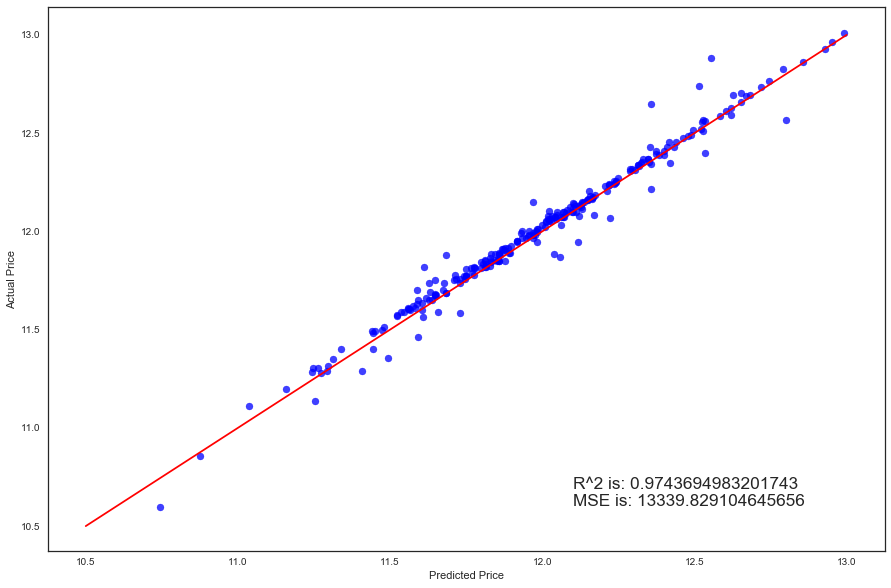

In [426]:
models = [model_gb,model_lgb,model_xgb,ridge_model]

all_preds , all_test_preds = trainModels(models,X_train,y_train,X_test,X)

meta_model = lm.fit(all_preds, y_test)

plotModelResult(meta_model,all_test_preds,y)

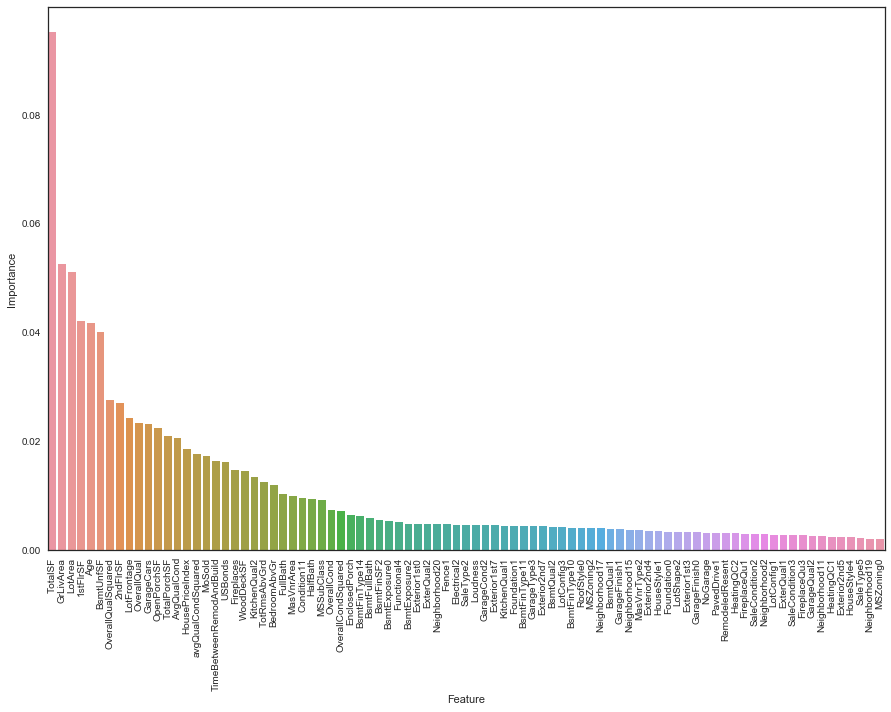

In [427]:
importances = model_gb.feature_importances_
columns = X_test.columns.values

feature_importance = list(zip(columns,importances))
sorted_feature_importance = np.array(sorted(feature_importance,key=lambda x : x[1],reverse=True))
sorted_feature_importance = list(map(lambda x : [x[0],float(x[1])],sorted_feature_importance))

featureImportanceDF = pd.DataFrame(data=sorted_feature_importance,columns=["Feature","Importance"]).query("Importance > 0.002")
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Feature", y="Importance",data=featureImportanceDF)

In [428]:
all_model_preds = predict(models,testData)

final_predictions = np.exp(lasso_model.predict(all_model_preds))

submission1 = pd.DataFrame()
submission1['Id'] = relevantTestDataIds
submission1['SalePrice'] = final_predictions
submission1.head(20)

,Id,SalePrice
0,1209,143740.233926
1,1222,119229.741292
2,1225,210025.058822
3,1227,198269.704947
4,1228,133779.706837
5,1229,325257.385685
6,1230,145189.983382
7,1235,117237.606946
8,1241,213634.476363
9,1249,153563.920382


## Non crisis model

In [429]:
trainData,testData,y,relevantTestDataIds = fetchData("YrSold != 2008")

In [430]:
X = trainData
training_features = X.columns.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

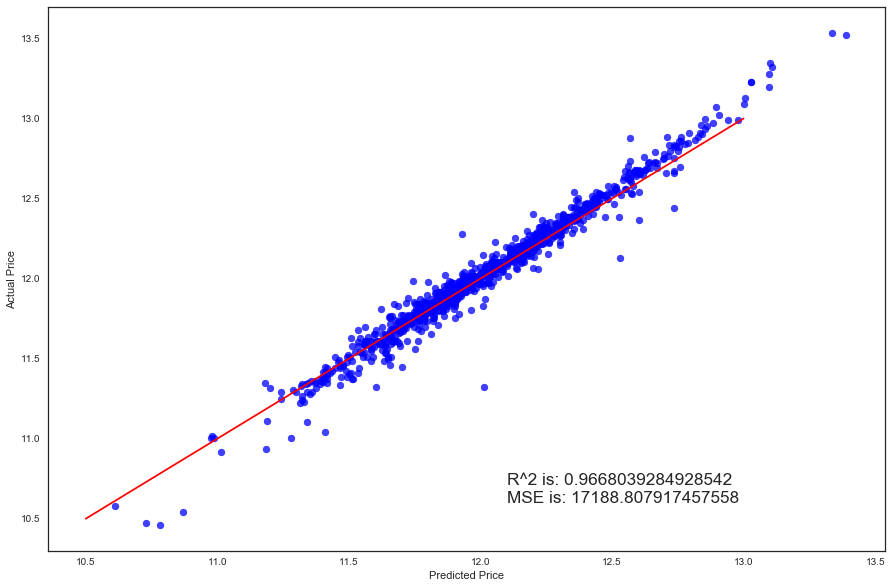

In [431]:
#models = [rm,model_gb,model_lgb,model_xgb,bayesian_model,randomForrestModel,svr_lin_model]

all_preds , all_test_preds = trainModels(models,X_train,y_train,X_test,X)

meta_model = lm.fit(all_preds, y_test)

plotModelResult(meta_model,all_test_preds,y)

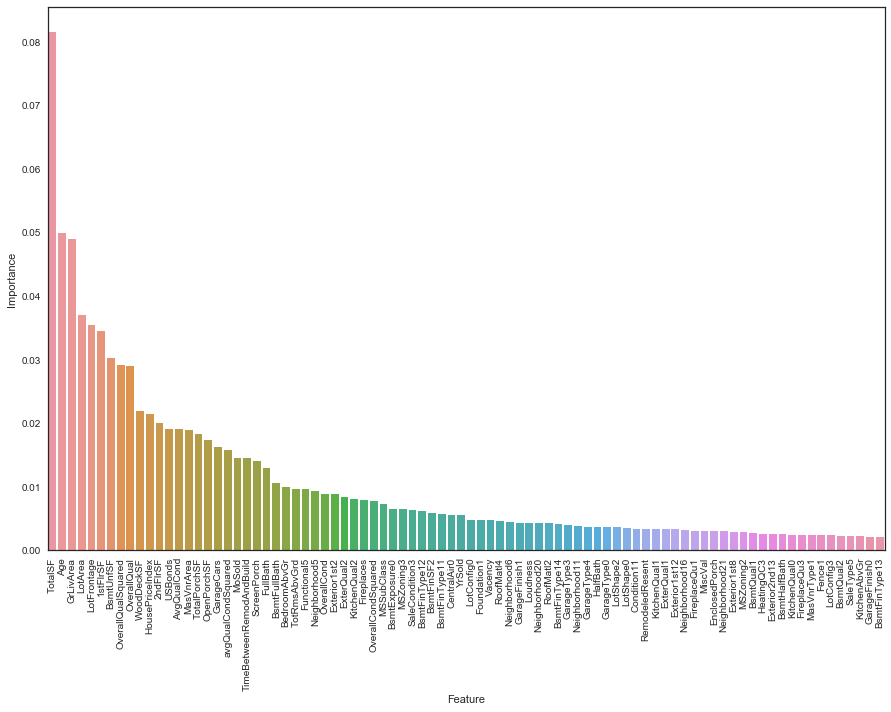

In [432]:
importances = model_gb.feature_importances_
columns = X_test.columns.values

feature_importance = list(zip(columns,importances))
sorted_feature_importance = np.array(sorted(feature_importance,key=lambda x : x[1],reverse=True))
sorted_feature_importance = list(map(lambda x : [x[0],float(x[1])],sorted_feature_importance))

featureImportanceDF = pd.DataFrame(data=sorted_feature_importance,columns=["Feature","Importance"]).query("Importance > 0.002")
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Feature", y="Importance",data=featureImportanceDF)

In [433]:
all_model_preds = predict(models,testData)

final_predictions = np.exp(meta_model.predict(all_model_preds))

submission2 = pd.DataFrame()
submission2['Id'] = relevantTestDataIds
submission2['SalePrice'] = final_predictions
submission2.head(20)

,Id,SalePrice
0,1201,103230.524579
1,1202,188868.460731
2,1203,128984.415464
3,1204,200386.991074
4,1205,151567.587516
5,1206,262534.023728
6,1207,112442.306638
7,1208,206678.671028
8,1210,271848.357145
9,1211,188510.188971


In [434]:
allSubmission = pd.concat([submission1,submission2]).sort_values("Id")
allSubmission.head(20)

,Id,SalePrice
0,1201,103230.524579
1,1202,188868.460731
2,1203,128984.415464
3,1204,200386.991074
4,1205,151567.587516
5,1206,262534.023728
6,1207,112442.306638
7,1208,206678.671028
0,1209,143740.233926
8,1210,271848.357145


In [435]:
allSubmission.to_csv('submission3.csv', index=False)

In [436]:
testDataDF = pd.read_csv(base + "train2.csv")
ansDF = pd.read_csv(base + "train2.csv")
idColl = ansDF.Id
ansDF = ansDF.drop(["Id"],axis=1)
ansDF.index = idColl
ansDF = pd.DataFrame(ansDF.SalePrice[1200:])
ansDF["Predicted"] = allSubmission.SalePrice.values
ansDF.head(20)

,SalePrice,Predicted
Id,,
1201,116050,103230.524579
1202,197900,188868.460731
1203,117000,128984.415464
1204,213000,200386.991074
1205,153500,151567.587516
1206,271900,262534.023728
1207,107000,112442.306638
1208,200000,206678.671028
1209,140000,143740.233926


In [437]:
ansDF["Diff"] = abs(ansDF["SalePrice"] - ansDF["Predicted"])
ansDF = ansDF.sort_values(by="Diff",ascending=False)
ansDF.head(20)

,SalePrice,Predicted,Diff
Id,,,
1299,160000,516409.592635,356409.592635
1325,147000,289112.935146,142112.935146
1374,466500,390601.669609,75898.330391
1244,465000,389627.794892,75372.205108
1387,250000,313560.581052,63560.581052
1454,84500,143164.893955,58664.893955
1424,274970,218368.493876,56601.506124
1212,164000,220259.600642,56259.600642
1354,410000,358330.990880,51669.009120


In [438]:
print("Root mean squared error:")
print(np.sqrt(mean_squared_error(ansDF["SalePrice"],ansDF["Predicted"])))

Root mean squared error:
30738.010087760304


In [439]:
worstPredictions = testDataDF.query("Id == 1299 | Id == 1325 | Id == 1244 | Id == 1374 | Id == 1311")
columns = np.concatenate((highestCorrFeatures,["Neighborhood","YrSold","MoSold"]))
worstPredictions[columns]

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,GarageArea,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,Neighborhood,YrSold,MoSold
1243,10,2076,2076,3,850,2076,2,7,2006,2006,NridgHt,2006,9
1298,10,5642,6110,2,1418,4692,2,12,2008,2008,Edwards,2008,1
1310,7,1902,1902,2,567,1902,2,7,1959,2002,Crawfor,2010,5
1324,8,1795,1795,3,895,1795,2,7,2006,2007,Somerst,2007,2
1373,10,2633,2633,3,804,2633,2,8,2001,2002,NoRidge,2007,3


# Evaluate models

In [440]:
bestModelCombination = None
lowest_value = None
queries = ["YrSold != 2008","YrSold == 2008"]
models = [ridge_model,model_gb,model_lgb,model_xgb,bayesian_model,svr_lin_model]
for L in range(3, len(models)+1):
    for model_subset in itertools.combinations(models, L):
        submissions = []
        for query in queries:
            trainData,testData,y,testIds = fetchData(query)
        
            X = trainData
            training_features = X.columns.values

            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)
            

            all_preds , all_test_preds = trainModels(model_subset,X_train,y_train,X_test,X)

            meta_model = lm.fit(all_preds, y_test)
            
            all_model_preds = predict(model_subset,testData)

            final_predictions = np.exp(meta_model.predict(all_model_preds))
            
            submission = pd.DataFrame()
            submission['Id'] = testIds
            submission['SalePrice'] = final_predictions
            submissions.append(submission)
            
        allSubmission = pd.concat(submissions).sort_values("Id")
        
        rmse = np.sqrt(mean_squared_error(ansDF["SalePrice"],allSubmission["SalePrice"]))
        print(rmse)
        
        if  lowest_value == None or rmse < lowest_value:
            bestModelCombination = subset
            lowest_value = rmse

print(bestModelCombination)
        

104929.98852210407


NameError: name 'subset' is not defined

# Stacking regressor